# Extension 6.1: Adaptive Re-ranking Strategy

## 1. Threshold Selection and Training
In this section, we define what a "hard query" is and determine an optimal inlier threshold $\tau$.
The goal is to stop the re-ranking process if the first retrieved candidate already shows a high number of inliers,
assuming the prediction is correct.

**Strategy:**
* Use **SVOX Sun Train** and **SVOX Night Train** to analyze the inlier distribution.
* Find the threshold $\tau$ that maximizes the F1-score or balances Precision/Recall on the training set.

Estrazione dataset

In [6]:
import zipfile
import os
from tqdm import tqdm

# ==============================================================================
# CONFIGURAZIONE
# ==============================================================================
BASE_DRIVE_PATH = "/content/drive/MyDrive"

# Lista dei dataset: (Nome File Zip, Cartella di Destinazione)
datasets_list = [
    ("sf_xs.zip", "/content/sf_xs"),
    ("svox.zip", "/content/svox"),
    ("tokyo_xs.zip", "/content/tokyo_xs")
]

# ==============================================================================
# SCRIPT DI ESTRAZIONE
# ==============================================================================
def unzip_dataset(zip_name, extract_to):
    zip_path = os.path.join(BASE_DRIVE_PATH, zip_name)

    if not os.path.exists(zip_path):
        print(f"❌ SALTATO: Non trovo {zip_name} in {BASE_DRIVE_PATH}")
        return

    print(f"\n📂 Estrazione di {zip_name} in {extract_to}...")

    os.makedirs(extract_to, exist_ok=True)

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # tqdm per barra di progresso
            for member in tqdm(zip_ref.infolist(), desc=f"Estraendo {zip_name}"):
                zip_ref.extract(member, extract_to)
        print(f"✅ {zip_name} estratto correttamente!")
    except zipfile.BadZipFile:
        print(f"❌ ERRORE: Il file {zip_name} sembra corrotto.")
    except Exception as e:
        print(f"❌ ERRORE Generico su {zip_name}: {e}")

# ==============================================================================
# ESECUZIONE LOOP
# ==============================================================================
if __name__ == "__main__":
    print(f"🚀 Inizio estrazione di {len(datasets_list)} dataset...")

    for zip_file, dest_folder in datasets_list:
        unzip_dataset(zip_file, dest_folder)

    print("\n✨ TUTTO COMPLETATO! I dataset sono pronti in /content/")

🚀 Inizio estrazione di 3 dataset...

📂 Estrazione di sf_xs.zip in /content/sf_xs...


Estraendo sf_xs.zip: 100%|██████████| 103869/103869 [00:38<00:00, 2724.57it/s]


✅ sf_xs.zip estratto correttamente!

📂 Estrazione di svox.zip in /content/svox...


Estraendo svox.zip: 100%|██████████| 104864/104864 [01:41<00:00, 1031.06it/s]


✅ svox.zip estratto correttamente!

📂 Estrazione di tokyo_xs.zip in /content/tokyo_xs...


Estraendo tokyo_xs.zip: 100%|██████████| 13090/13090 [00:04<00:00, 3030.32it/s]

✅ tokyo_xs.zip estratto correttamente!

✨ TUTTO COMPLETATO! I dataset sono pronti in /content/


Mounting Drive

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
from google.colab import drive

print("🔌 Smontaggio di Google Drive in corso...")

try:
    # Questo comando forza la scrittura dei dati in sospeso e smonta il drive
    drive.flush_and_unmount()
    print("✅ Google Drive smontato con successo!")
except Exception as e:
    print(f"⚠️ Errore (forse il Drive non era montato): {e}")

🔌 Smontaggio di Google Drive in corso...
✅ Google Drive smontato con successo!


## Selezione della Soglia (SVOX Sun Train)
In questa fase analizziamo i dati di addestramento per definire cosa rende una query "facile" o "difficile". Utilizziamo l'F1-Score come metrica di riferimento perché bilancia la precisione (non scambiare un errore per un match facile) e la recall (identificare correttamente i match facili per risparmiare calcoli).

## LoFTR

### Come trovo TAU?
Per capire se siamo incerti, usiamo il numero di Inliers (i punti in comune trovati tra le due immagini).

1. Il modello fa una prima previsione veloce (Retrieval).
2. Contiamo quanti punti combaciano (Inliers) con la prima immagine trovata.
3. Confrontiamo questo numero con una soglia di sicurezza, chiamata $\tau$ ("tau"):
* Se Inliers > $\tau$ (Tanti punti in comune) $\rightarrow$ La query è FACILE. Ci fidiamo subito, risparmiando tempo.
* Se Inliers $\le \tau$ (Pochi punti in comune) $\rightarrow$ La query è DIFFICILE. Non ci fidiamo, quindi attiviamo il Re-ranking per controllare meglio.





### TAU SVOX Sun Train LoFTR

📂 Base Path: /content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/train/svox_sun_train


Lettura .torch: 100%|██████████| 712/712 [00:06<00:00, 118.18it/s]


✅ Dati caricati: 712 query comuni trovate.


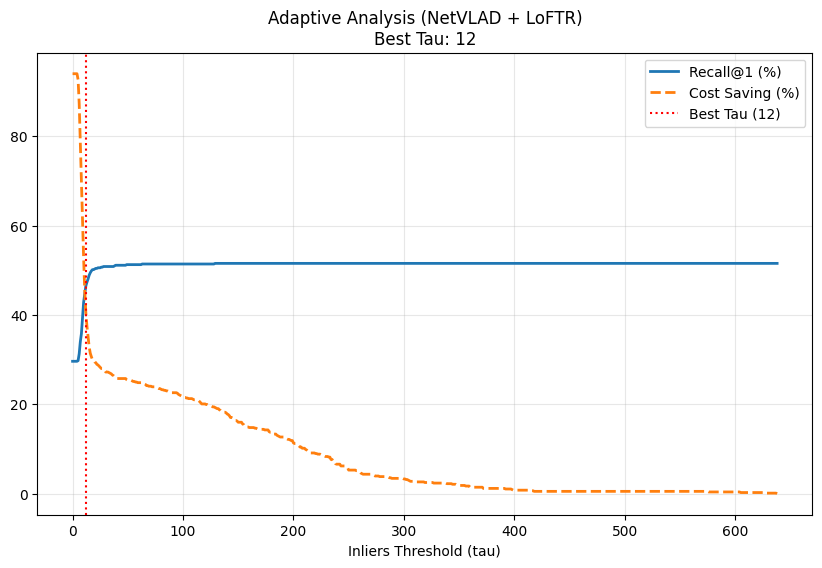


--- RISULTATI ADAPTIVE (Best Tau: 12) ---
Tau   | Recall     | Saving     | F2-Score  
--------------------------------------------------
0     | 29.63%    | 93.99%    | 0.3434     
5     | 29.78%    | 92.66%    | 0.3445     
10    | 42.84%    | 52.74%    | 0.4451     
12    | 46.49%    | 40.58%    | 0.4517     ⭐ BEST
15    | 48.88%    | 32.91%    | 0.4456     
20    | 50.28%    | 29.48%    | 0.4406     
25    | 50.56%    | 28.29%    | 0.4368     
30    | 50.84%    | 27.23%    | 0.4333     
35    | 50.84%    | 26.83%    | 0.4313     
40    | 51.12%    | 25.78%    | 0.4272     
45    | 51.12%    | 25.78%    | 0.4272     
50    | 51.26%    | 25.38%    | 0.4258     
55    | 51.26%    | 25.12%    | 0.4243     
60    | 51.26%    | 24.85%    | 0.4228     
65    | 51.40%    | 24.59%    | 0.4220     
70    | 51.40%    | 24.06%    | 0.4188     
75    | 51.40%    | 23.79%    | 0.4172     
80    | 51.40%    | 23.40%    | 0.4148     
85    | 51.40%    | 23.00%    | 0.4122     
90    | 51.40%    |

In [41]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURAZIONE
# ==============================================================================

# Percorso base che mi hai fornito
BASE_PATH = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/train/svox_sun_train"

# Cartella con i file .txt (Ground Truth Retrieval)
TXT_PREDS_FOLDER = os.path.join(BASE_PATH, "preds")

# Cartella con i file .torch (Inliers)
TORCH_FOLDER = os.path.join(BASE_PATH, "preds_loftr")

# File CSV con i risultati finali (Ground Truth Re-ranking)
CSV_FILE = os.path.join(BASE_PATH, "stats_preds_loftr.csv")

# Latenze stimate (secondi)
TIME_GLOBAL = 0.20
TIME_RERANK = 3.20

# Peso per F-beta score (2.0 privilegia la Recall rispetto al Saving)
FBETA = 2.0

# ==============================================================================
# 2. FUNZIONI DI PARSING (Logica "Amico")
# ==============================================================================

def norm_qid(x) -> str | None:
    """Normalizza query id a stringa di 3 cifre (es. 7 -> '007')."""
    try:
        return f"{int(float(x)):03d}"
    except Exception:
        return None

def parse_preds_txt(txt_path: str) -> dict | None:
    """
    Legge il file .txt e controlla se la prima predizione (Rank 0)
    è contenuta nella lista dei 'Positives paths'.
    """
    qid = norm_qid(Path(txt_path).stem)
    if qid is None:
        return None

    with open(txt_path, "r", encoding="utf-8") as f:
        lines = [ln.strip() for ln in f.readlines()]

    def find_idx(prefix: str):
        for i, ln in enumerate(lines):
            if ln.lower().startswith(prefix.lower()):
                return i
        return None

    i_pred = find_idx("Predictions paths")
    i_pos = find_idx("Positives paths")

    if i_pred is None or i_pos is None or i_pos <= i_pred:
        return None

    # Estrai le righe
    pred_lines = [ln for ln in lines[i_pred + 1 : i_pos] if ln and not ln.endswith(":")]
    pos_lines = [ln for ln in lines[i_pos + 1 :] if ln and not ln.endswith(":")]

    if len(pred_lines) == 0:
        return None

    rank0 = pred_lines[0]
    positives = set(pos_lines)

    # VERITÀ ASSOLUTA: Rank 0 è corretto se è nella lista dei positivi
    retrieval_is_correct = 1 if rank0 in positives else 0

    return {"query_id": qid, "retrieval_is_correct": retrieval_is_correct}

def load_data(txt_folder, torch_folder, csv_path):
    # 1. Carica Retrieval GT dai .txt
    txt_files = glob(os.path.join(txt_folder, "*.txt"))
    if not txt_files:
        raise RuntimeError(f"Nessun file .txt trovato in {txt_folder}")

    rows_txt = []
    for p in tqdm(txt_files, desc="Lettura .txt"):
        d = parse_preds_txt(p)
        if d: rows_txt.append(d)
    df_ret = pd.DataFrame(rows_txt)

    # 2. Carica Final GT dal CSV
    if not os.path.exists(csv_path):
        raise RuntimeError(f"CSV non trovato: {csv_path}")
    df_csv = pd.read_csv(csv_path)

    # Gestione nomi colonne variabili
    col_corr = 'is_correct' if 'is_correct' in df_csv.columns else 'final_is_correct'
    df_csv['query_id'] = df_csv['query_id'].apply(norm_qid)
    df_final = df_csv[['query_id', col_corr]].rename(columns={col_corr: 'final_is_correct'})

    # 3. Carica Inliers dai .torch (Solo per le query comuni)
    common_qids = set(df_ret['query_id']) & set(df_final['query_id'])
    rows_torch = []

    for qid in tqdm(common_qids, desc="Lettura .torch"):
        # Cerca il file con vari formati possibili (007.torch, 7.torch...)
        candidates = [
            os.path.join(torch_folder, f"{qid}.torch"),
            os.path.join(torch_folder, f"{int(qid)}.torch"),
            os.path.join(torch_folder, f"{int(qid):05d}.torch")
        ]
        found = False
        for p in candidates:
            if os.path.exists(p):
                try:
                    data = torch.load(p, weights_only=False)
                    if data and 'num_inliers' in data[0]:
                        rows_torch.append({
                            "query_id": qid,
                            "inliers_rank0": int(data[0]['num_inliers'])
                        })
                        found = True
                        break
                except:
                    pass

    df_inl = pd.DataFrame(rows_torch)

    # 4. Merge finale
    df = df_ret.merge(df_final, on='query_id').merge(df_inl, on='query_id')
    return df

# ==============================================================================
# 3. SIMULAZIONE E CALCOLO TAU
# ==============================================================================

def fbeta_score(recall, saving, beta=2.0):
    """Calcola F-beta score combinando Recall e Saving (normalizzati 0-1)"""
    r = recall / 100.0
    s = saving / 100.0
    if (beta**2 * s + r) == 0: return 0
    return (1 + beta**2) * (r * s) / (beta**2 * s + r)

def run_simulation(df):
    max_inl = df['inliers_rank0'].max()
    thresholds = np.arange(0, max_inl + 1, 1)

    results = []
    total = len(df)
    full_cost = total * (TIME_GLOBAL + TIME_RERANK)

    for tau in thresholds:
        # Se inliers > tau --> EASY (Uso Retrieval)
        # Se inliers <= tau --> HARD (Uso Final/Re-rank)
        is_easy = df['inliers_rank0'] > tau

        # Calcolo Hits (Corretti)
        hits = np.where(is_easy, df['retrieval_is_correct'], df['final_is_correct']).sum()
        recall = (hits / total) * 100

        # Calcolo Costi
        n_easy = is_easy.sum()
        n_hard = total - n_easy
        current_cost = (n_easy * TIME_GLOBAL) + (n_hard * (TIME_GLOBAL + TIME_RERANK))
        saving = (1 - (current_cost / full_cost)) * 100

        # F2 Score (Bilancia R e S, preferendo R)
        f2 = fbeta_score(recall, saving, beta=FBETA)

        results.append({
            'tau': tau,
            'recall': recall,
            'saving': saving,
            'f2': f2
        })

    return pd.DataFrame(results)

# ==============================================================================
# MAIN
# ==============================================================================

if __name__ == "__main__":
    print(f"📂 Base Path: {BASE_PATH}")

    # 1. Caricamento
    try:
        df = load_data(TXT_PREDS_FOLDER, TORCH_FOLDER, CSV_FILE)
        print(f"✅ Dati caricati: {len(df)} query comuni trovate.")
    except Exception as e:
        print(f"❌ Errore caricamento: {e}")
        exit()

    # 2. Analisi
    res = run_simulation(df)

    # 3. Trova il miglior Tau
    best_row = res.loc[res['f2'].idxmax()]
    best_tau = int(best_row['tau'])

    # 4. Grafico
    plt.figure(figsize=(10,6))
    plt.plot(res['tau'], res['recall'], label='Recall@1 (%)', linewidth=2)
    plt.plot(res['tau'], res['saving'], label='Cost Saving (%)', linestyle='--', linewidth=2)
    plt.axvline(best_tau, color='r', linestyle=':', label=f'Best Tau ({best_tau})')
    plt.xlabel('Inliers Threshold (tau)')
    plt.title(f'Adaptive Analysis (NetVLAD + LoFTR)\nBest Tau: {best_tau}')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # 5. Stampa Tabella
    print(f"\n--- RISULTATI ADAPTIVE (Best Tau: {best_tau}) ---")
    print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F2-Score':<10}")
    print("-" * 50)

    # Stampa step ogni 5, ma includi sempre il best tau
    indices = sorted(list(set(range(0, 101, 5)) | {best_tau}))
    for t in indices:
        if t < len(res):
            row = res.iloc[t]
            marker = "⭐ BEST" if t == best_tau else ""
            print(f"{int(row['tau']):<5} | {row['recall']:.2f}%    | {row['saving']:.2f}%    | {row['f2']:.4f}     {marker}")

### TAU Svox Night train Loftr

--- Caricamento Dati: SVOX NIGHT (LoFTR) ---


Loading Torch: 100%|██████████| 702/702 [00:06<00:00, 111.92it/s]


✅ Analisi su 702 query.


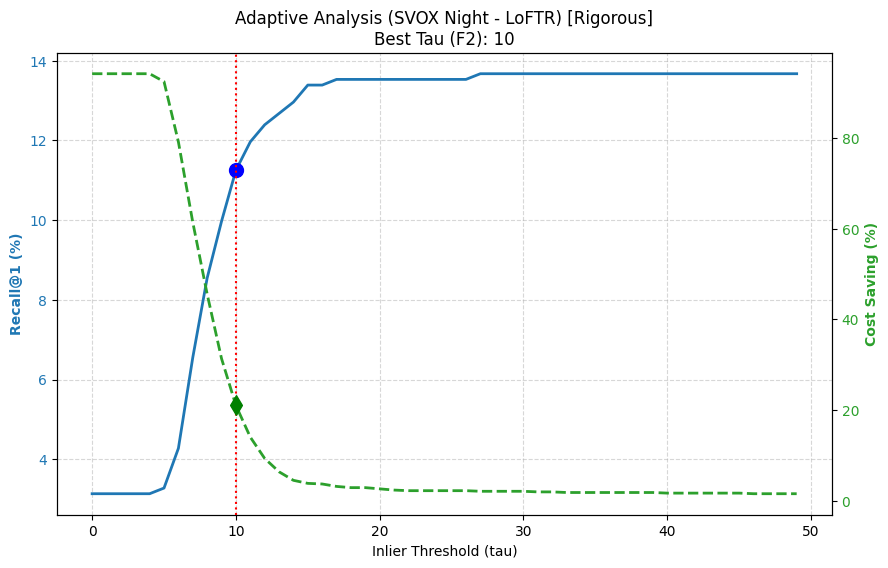


--- TRADE-OFF TABLE (SVOX NIGHT, F2-Score) ---
Tau   | Recall     | Saving     | F2-Score   | Note
-----------------------------------------------------------------
0     | 3.13%    | 94.12%    | 0.0389     | 
5     | 3.28%    | 92.37%    | 0.0406     | 
10    | 11.25%    | 21.05%    | 0.1241     | ⭐ BEST
15    | 13.39%    | 3.89%    | 0.0899     | 
20    | 13.53%    | 2.68%    | 0.0748     | 
25    | 13.53%    | 2.28%    | 0.0681     | 
30    | 13.68%    | 2.15%    | 0.0659     | 
35    | 13.68%    | 1.88%    | 0.0606     | 
40    | 13.68%    | 1.74%    | 0.0577     | 
45    | 13.68%    | 1.74%    | 0.0577     | 
50    | 13.68%    | 1.47%    | 0.0515     | 
55    | 13.68%    | 1.47%    | 0.0515     | 
60    | 13.68%    | 1.34%    | 0.0482     | 
65    | 13.68%    | 1.34%    | 0.0482     | 
70    | 13.68%    | 1.21%    | 0.0446     | 
75    | 13.68%    | 1.07%    | 0.0408     | 
80    | 13.68%    | 1.07%    | 0.0408     | 
85    | 13.68%    | 1.07%    | 0.0408     | 
90    | 13.68%   

In [43]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURAZIONE (SVOX NIGHT TRAIN - LOFTR)
# ==============================================================================

# Percorso base: SVOX NIGHT TRAIN
BASE_PATH = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/train/svox_night_train"

# Cartelle specifiche
TXT_PREDS_FOLDER = os.path.join(BASE_PATH, "preds")          # Ground Truth Retrieval (.txt)
TORCH_FOLDER = os.path.join(BASE_PATH, "preds_loftr")        # Inliers (.torch)
CSV_FILE = os.path.join(BASE_PATH, "stats_preds_loftr.csv")  # Risultati Finali (.csv)

# Parametri
TIME_GLOBAL = 0.20
TIME_RERANK = 3.20
FBETA = 2.0  # F2-Score

# ==============================================================================
# 2. FUNZIONI DI CARICAMENTO (RIGOROSO)
# ==============================================================================

def norm_qid(x) -> str | None:
    try:
        return f"{int(float(x)):03d}"
    except Exception:
        return None

def parse_preds_txt(txt_path: str) -> dict | None:
    """Legge il .txt e verifica se Rank 0 è nei Positives (Ground Truth Reale)"""
    qid = norm_qid(Path(txt_path).stem)
    if qid is None: return None

    with open(txt_path, "r", encoding="utf-8") as f:
        lines = [ln.strip() for ln in f.readlines()]

    try:
        i_pred = next(i for i, x in enumerate(lines) if x.startswith("Predictions paths"))
        i_pos = next(i for i, x in enumerate(lines) if x.startswith("Positives paths"))
    except StopIteration:
        return None

    pred_lines = [ln for ln in lines[i_pred + 1 : i_pos] if ln and not ln.endswith(":")]
    pos_lines = [ln for ln in lines[i_pos + 1 :] if ln and not ln.endswith(":")]

    if not pred_lines: return None

    rank0 = pred_lines[0]
    positives = set(pos_lines)

    # Rigoroso: Rank 0 è corretto se presente nei positivi
    retrieval_is_correct = 1 if rank0 in positives else 0
    return {"query_id": qid, "retrieval_is_correct": retrieval_is_correct}

def load_data(txt_folder, torch_folder, csv_path):
    print(f"--- Caricamento Dati: SVOX NIGHT (LoFTR) ---")

    # 1. Carica TXT
    if not os.path.exists(txt_folder):
        print(f"❌ Errore: Cartella TXT non trovata: {txt_folder}")
        return pd.DataFrame()

    txt_files = glob(os.path.join(txt_folder, "*.txt"))
    rows = [parse_preds_txt(p) for p in tqdm(txt_files, desc="Parsing TXT")]
    rows = [r for r in rows if r is not None]
    df_ret = pd.DataFrame(rows)

    # 2. Carica CSV
    if not os.path.exists(csv_path):
        print(f"❌ Errore: CSV non trovato: {csv_path}")
        return pd.DataFrame()

    df_csv = pd.read_csv(csv_path)
    col_corr = 'is_correct' if 'is_correct' in df_csv.columns else 'final_is_correct'
    df_csv['query_id'] = df_csv['query_id'].apply(norm_qid)
    df_final = df_csv[['query_id', col_corr]].rename(columns={col_corr: 'final_is_correct'})

    # 3. Carica Torch
    common_qids = set(df_ret['query_id']) & set(df_final['query_id'])
    rows_torch = []

    for qid in tqdm(common_qids, desc="Loading Torch"):
        candidates = [
            os.path.join(torch_folder, f"{qid}.torch"),
            os.path.join(torch_folder, f"{int(qid)}.torch"),
            os.path.join(torch_folder, f"{int(qid):05d}.torch")
        ]
        for p in candidates:
            if os.path.exists(p):
                try:
                    data = torch.load(p, weights_only=False)
                    if data and 'num_inliers' in data[0]:
                        rows_torch.append({
                            "query_id": qid,
                            "inliers_rank0": int(data[0]['num_inliers'])
                        })
                        break
                except: pass

    df_inl = pd.DataFrame(rows_torch)

    if df_inl.empty:
        print("❌ Warning: Nessun inlier caricato.")
        return pd.DataFrame()

    df = df_ret.merge(df_final, on='query_id').merge(df_inl, on='query_id')
    return df

# ==============================================================================
# 3. ANALISI
# ==============================================================================

def fbeta_score(recall, saving, beta=2.0):
    r = recall / 100.0
    s = saving / 100.0
    if (beta**2 * s + r) == 0: return 0
    return (1 + beta**2) * (r * s) / (beta**2 * s + r)

def run_simulation(df):
    max_inl = df['inliers_rank0'].max()
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings, f2_vals = [], [], []
    total = len(df)
    full_time = total * (TIME_GLOBAL + TIME_RERANK)

    for tau in thresholds:
        is_easy = df['inliers_rank0'] > tau
        hits = np.where(is_easy, df['retrieval_is_correct'], df['final_is_correct']).sum()
        rec = (hits / total) * 100

        n_easy = is_easy.sum()
        n_hard = total - n_easy
        curr_time = (n_easy * TIME_GLOBAL) + (n_hard * (TIME_GLOBAL + TIME_RERANK))
        sav = (1 - (curr_time / full_time)) * 100

        recalls.append(rec)
        savings.append(sav)
        f2_vals.append(fbeta_score(rec, sav, beta=FBETA))

    return thresholds, recalls, savings, f2_vals

# ==============================================================================
# MAIN
# ==============================================================================
if __name__ == "__main__":

    df = load_data(TXT_PREDS_FOLDER, TORCH_FOLDER, CSV_FILE)

    if not df.empty:
        print(f"✅ Analisi su {len(df)} query.")
        th, rec, sav, f2 = run_simulation(df)

        # Best Tau
        best_idx = np.argmax(f2)
        best_tau = th[best_idx]

        # --- STILE GRAFICO RICHIESTO ---
        limit_plot = min(50, len(th)) # Zoom sui primi 50

        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Asse Y1: Recall (Blu - Solido)
        color_rec = 'tab:blue'
        ax1.set_xlabel('Inlier Threshold (tau)')
        ax1.set_ylabel('Recall@1 (%)', color=color_rec, fontweight='bold')
        ax1.plot(th[:limit_plot], rec[:limit_plot], color=color_rec, linewidth=2, label='Recall@1')
        ax1.tick_params(axis='y', labelcolor=color_rec)
        ax1.grid(True, linestyle='--', alpha=0.5)

        # Asse Y2: Saving (Verde - Tratteggiato)
        color_sav = 'tab:green'
        ax2 = ax1.twinx()
        ax2.set_ylabel('Cost Saving (%)', color=color_sav, fontweight='bold')
        ax2.plot(th[:limit_plot], sav[:limit_plot], color=color_sav, linestyle='--', linewidth=2, label='Cost Saving')
        ax2.tick_params(axis='y', labelcolor=color_sav)

        # Marcatori (Pallino Blu e Rombo Verde)
        ax1.scatter(best_tau, rec[best_idx], color='blue', s=100, zorder=10) # Pallino blu
        ax2.scatter(best_tau, sav[best_idx], color='green', marker='d', s=100, zorder=10) # Rombo verde

        # Linea verticale rossa
        plt.axvline(x=best_tau, color='red', linestyle=':', label=f'Best Tau={best_tau}')

        plt.title(f'Adaptive Analysis (SVOX Night - LoFTR) [Rigorous]\nBest Tau (F2): {best_tau}')
        plt.show()

        # Tabella
        print(f"\n--- TRADE-OFF TABLE (SVOX NIGHT, F2-Score) ---")
        print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F2-Score':<10} | {'Note'}")
        print("-" * 65)

        indices = sorted(list(set(range(0, 101, 5)) | {best_tau}))
        for t_val in indices:
            if t_val < len(th):
                idx = np.where(th == t_val)[0][0]
                marker = "⭐ BEST" if t_val == best_tau else ""
                print(f"{t_val:<5} | {rec[idx]:.2f}%    | {sav[idx]:.2f}%    | {f2[idx]:.4f}     | {marker}")

### Validazione su sf_xs val
**Tau scelto: 10**

Obiettivo:Dopo aver determinato la soglia ottimale sui dataset di training (SVOX Sun/Night), è fondamentale validarne la robustezza su un dataset mai visto e proveniente da un dominio geografico diverso: San Francisco eXtra Small (SF-XS Val).Metodologia:
* Applichiamo la soglia "congelata" derivata dall'analisi precedente:LoFTR: $\tau = 10$ (Valore selezionato dall'analisi su SVOX)

Valutiamo la Recall@1 e il Risparmio Computazionale su SF-XS Val utilizzando questo valore fisso. Se il sistema è robusto, ci aspettiamo che la soglia $\tau=10$ mantenga una buona precisione senza sacrificare troppo il risparmio, confermando che il parametro non è in "overfitting" sui dati di training.

### Generazione txt e jpg da preds.npy


In [24]:
import os
import numpy as np
from glob import glob
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

# ==============================================================================
# 1. FUNZIONI DI SUPPORTO (Parsing & Loading)
# ==============================================================================

def parse_utm_from_filename(filename):
    """
    Estrae le coordinate UTM dal nome del file.
    Formato tipico: '@EASTING@NORTHING@...'
    """
    try:
        parts = filename.split('@')
        # Gestione robusta: se inizia con @ il primo elemento è vuoto
        if filename.startswith('@'):
             utm_east = float(parts[1])
             utm_north = float(parts[2])
        else:
             # Caso fallback id_@...
             utm_east = float(parts[1])
             utm_north = float(parts[2])
        return np.array([utm_east, utm_north])
    except Exception:
        return None

def load_paths_and_utms(folder_path):
    print(f"📂 Scansione cartella: {folder_path}")

    if not os.path.exists(folder_path):
        print(f"❌ ERRORE GRAVE: La cartella non esiste: {folder_path}")
        return [], np.array([])

    extensions = ['*.jpg', '*.jpeg', '*.png']
    files = []
    for ext in extensions:
        files.extend(glob(os.path.join(folder_path, ext)))

    # ⚠️ ORDINAMENTO ALFABETICO: CRUCIALE per allinearsi con preds.npy
    files.sort()

    paths = []
    utms = []

    for fpath in files:
        fname = os.path.basename(fpath)
        utm = parse_utm_from_filename(fname)
        if utm is not None:
            paths.append(fpath)
            utms.append(utm)

    if len(paths) == 0:
        print(f"⚠️ ATTENZIONE: Nessuna immagine trovata in {folder_path}!")

    return paths, np.array(utms)

def generate_txt_for_split(dataset_root, preds_npy_path, output_txt_folder, split_name):
    print(f"\n==========================================")
    print(f"🚀 ELABORAZIONE: {split_name}")
    print(f"==========================================")

    # 1. Carica Immagini (Database e Queries)
    # Struttura standard: root/database e root/queries
    db_folder = os.path.join(dataset_root, "database")
    q_folder = os.path.join(dataset_root, "queries")

    db_paths, db_utms = load_paths_and_utms(db_folder)
    q_paths, q_utms = load_paths_and_utms(q_folder)

    print(f"📊 Statistiche {split_name}:")
    print(f"   Database: {len(db_paths)} immagini")
    print(f"   Queries:  {len(q_paths)} immagini")

    if len(db_paths) == 0 or len(q_paths) == 0:
        print("❌ STOP: Impossibile procedere senza immagini.")
        return

    # 2. Carica Predizioni
    if not os.path.exists(preds_npy_path):
        print(f"❌ Errore: preds.npy non trovato in {preds_npy_path}")
        return
    preds = np.load(preds_npy_path)
    print(f"✅ Predizioni caricate: {preds.shape}")

    # Controllo dimensioni
    limit = min(len(preds), len(q_paths))
    if len(preds) != len(q_paths):
        print(f"⚠️ WARNING: Numero queries ({len(q_paths)}) diverso da predizioni ({len(preds)}). Uso il minimo: {limit}")

    # 3. Costruzione Indice Spaziale (Ground Truth)
    print("⚙️ Costruzione indice spaziale (KNN)...")
    knn = NearestNeighbors(n_jobs=-1)
    knn.fit(db_utms)

    # 4. Generazione File .txt
    os.makedirs(output_txt_folder, exist_ok=True)
    print(f"💾 Generazione {limit} file .txt in: {output_txt_folder}")

    POS_THRESHOLD = 25.0  # Soglia standard 25 metri

    for i in tqdm(range(limit), desc=f"Generando TXT {split_name}"):
        q_path_full = q_paths[i]
        q_utm = q_utms[i].reshape(1, -1)

        pred_indices = preds[i]

        # Recupera i path delle predizioni (Rank 1..N)
        current_pred_paths = []
        for idx in pred_indices:
            if idx < len(db_paths):
                current_pred_paths.append(db_paths[idx])
            else:
                current_pred_paths.append("INDEX_ERROR")

        # Calcola i veri positivi (Ground Truth) basati sulla distanza GPS
        _, pos_indices_array = knn.radius_neighbors(q_utm, radius=POS_THRESHOLD)
        pos_indices = pos_indices_array[0]

        true_pos_paths = [db_paths[idx] for idx in pos_indices]
        if not true_pos_paths:
            true_pos_paths = ["NO_POSITIVES_FOUND"]

        # Scrittura su file
        filename = f"{i:03d}.txt"
        with open(os.path.join(output_txt_folder, filename), "w") as f:
            f.write("Query path:\n")
            f.write(f"{q_path_full}\n")
            f.write("Predictions paths:\n")
            for p in current_pred_paths:
                f.write(f"{p}\n")
            f.write("Positives paths:\n")
            for p in true_pos_paths:
                f.write(f"{p}\n")

    print(f"✅ Completato {split_name}!")

# ==============================================================================
# 2. CONFIGURAZIONE ED ESECUZIONE
# ==============================================================================

if __name__ == "__main__":

    # -------------------------------------------------------------------------
    # 1. SF-XS VAL
    # -------------------------------------------------------------------------
    SF_VAL_ROOT = "/content/sf_xs/sf_xs/val"

    # Percorsi Drive per VAL
    SF_VAL_PREDS = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_sf_xs/val/preds/preds.npy"
    SF_VAL_OUT = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_sf_xs/val/preds_txt_generated"

    if os.path.exists(SF_VAL_ROOT):
        generate_txt_for_split(SF_VAL_ROOT, SF_VAL_PREDS, SF_VAL_OUT, "SF-XS VAL")
    else:
        print(f"❌ Root VAL non trovata: {SF_VAL_ROOT}")


    # -------------------------------------------------------------------------
    # 2. SF-XS TEST
    # -------------------------------------------------------------------------
    SF_TEST_ROOT = "/content/sf_xs/sf_xs/test"

    # Percorsi Drive per TEST (Assicurati che esistano!)
    SF_TEST_PREDS = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_sf_xs/test/preds/preds.npy"
    SF_TEST_OUT = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_sf_xs/test/preds_txt_generated"

    if os.path.exists(SF_TEST_ROOT):
        generate_txt_for_split(SF_TEST_ROOT, SF_TEST_PREDS, SF_TEST_OUT, "SF-XS TEST")
    else:
        print(f"❌ Root TEST non trovata: {SF_TEST_ROOT}")


🚀 ELABORAZIONE: SF-XS VAL
📂 Scansione cartella: /content/sf_xs/sf_xs/val/database
📂 Scansione cartella: /content/sf_xs/sf_xs/val/queries
📊 Statistiche SF-XS VAL:
   Database: 8015 immagini
   Queries:  7993 immagini
✅ Predizioni caricate: (7993, 20)
⚙️ Costruzione indice spaziale (KNN)...
💾 Generazione 7993 file .txt in: /content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_sf_xs/val/preds_txt_generated


Generando TXT SF-XS VAL: 100%|██████████| 7993/7993 [03:26<00:00, 38.65it/s]


✅ Completato SF-XS VAL!

🚀 ELABORAZIONE: SF-XS TEST
📂 Scansione cartella: /content/sf_xs/sf_xs/test/database
📂 Scansione cartella: /content/sf_xs/sf_xs/test/queries
📊 Statistiche SF-XS TEST:
   Database: 27191 immagini
   Queries:  1000 immagini
✅ Predizioni caricate: (1000, 20)
⚙️ Costruzione indice spaziale (KNN)...
💾 Generazione 1000 file .txt in: /content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_sf_xs/test/preds_txt_generated


Generando TXT SF-XS TEST: 100%|██████████| 1000/1000 [00:26<00:00, 37.81it/s]

✅ Completato SF-XS TEST!



--- Caricamento Dati Rigorosi (da TXT) ---
📂 Parsing di 7993 file .txt...


Parsing TXT: 100%|██████████| 7993/7993 [02:26<00:00, 54.57it/s] 


📄 Lettura CSV: loftr_val.csv


Loading Torch: 100%|██████████| 1000/1000 [00:07<00:00, 128.11it/s]



--- TRADE-OFF TABLE: SF-XS Validation (0-100) ---
Tau   | Recall     | Saving     | F2-Score   | Note
-----------------------------------------------------------------
0     | 46.30%    | 94.12%    | 0.5154     | 
5     | 46.30%    | 94.02%    | 0.5153     | 
10    | 52.70%    | 78.49%    | 0.5641     | ⬅️ CHOSEN 
15    | 60.10%    | 61.74%    | 0.6042     | 
20    | 63.20%    | 53.46%    | 0.6098     | 
24    | 66.60%    | 48.09%    | 0.6184     | ⭐ MAX F2 
25    | 66.80%    | 47.06%    | 0.6163     | 
30    | 68.00%    | 44.14%    | 0.6137     | 
35    | 68.90%    | 42.35%    | 0.6122     | 
40    | 69.40%    | 41.51%    | 0.6118     | 
45    | 69.40%    | 40.85%    | 0.6089     | 
50    | 69.70%    | 39.53%    | 0.6047     | 
55    | 69.70%    | 39.25%    | 0.6034     | 
60    | 69.70%    | 38.96%    | 0.6020     | 
65    | 69.70%    | 38.49%    | 0.5998     | 
70    | 69.80%    | 37.27%    | 0.5943     | 
75    | 69.80%    | 36.80%    | 0.5919     | 
80    | 69.80%    | 36.52%    

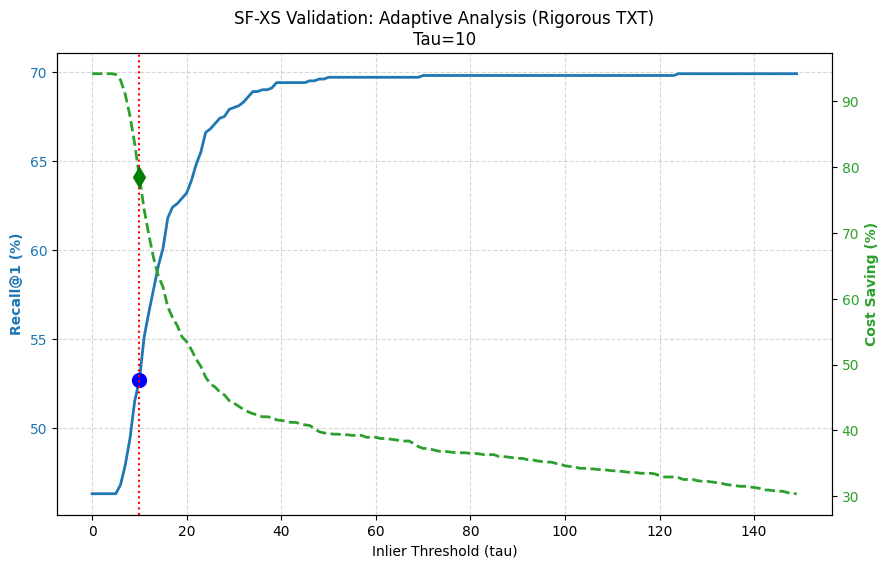



📊 FINAL COMPARISON (Re-rank Always vs Adaptive)
Dataset         | Metric     | Baseline (Always)  | Adaptive (Tau=10)    | Delta
-----------------------------------------------------------------------------------------------
SF-XS Val       | Recall     | 69.90              % | 52.70                % | -17.20
                | Saving     | 0.00               % | 78.49                % | +78.49


In [26]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURAZIONE PERCORSI (SF-XS VAL)
# ==============================================================================

# Percorso base
BASE_PATH = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_sf_xs/val"

# 1. Cartella TXT (Appena generati)
TXT_FOLDER = os.path.join(BASE_PATH, "preds_txt_generated")

# 2. Cartella Torch (Inliers)
TORCH_FOLDER = os.path.join(BASE_PATH, "preds_loftr")

# 3. File CSV (Risultati finali)
# Cerca il file csv corretto
POSSIBLE_CSVS = [
    os.path.join(BASE_PATH, "loftr_val.csv"),
    os.path.join(BASE_PATH, "stats_preds_loftr.csv"),
    os.path.join(BASE_PATH, "loftr_sf_xs_val.csv")
]
CSV_FILE = next((f for f in POSSIBLE_CSVS if os.path.exists(f)), None)

# Tau Default (puoi cambiarlo se vuoi evidenziarne un altro)
CHOSEN_TAU = 10

# Parametri
TIME_GLOBAL = 0.20
TIME_RERANK = 3.20
FBETA = 2.0

# ==============================================================================
# 2. FUNZIONI DI CARICAMENTO (RIGOROSO da TXT)
# ==============================================================================

def norm_qid(x) -> str | None:
    try:
        return f"{int(float(x)):03d}"
    except Exception:
        return None

def parse_preds_txt(txt_path: str) -> dict | None:
    """Legge il .txt e controlla se Rank 0 è nei Positives"""
    qid = norm_qid(Path(txt_path).stem)
    if qid is None: return None

    with open(txt_path, "r", encoding="utf-8") as f:
        lines = [ln.strip() for ln in f.readlines()]

    try:
        i_pred = next(i for i, x in enumerate(lines) if x.startswith("Predictions paths"))
        i_pos = next(i for i, x in enumerate(lines) if x.startswith("Positives paths"))
    except StopIteration:
        return None

    pred_lines = [ln for ln in lines[i_pred + 1 : i_pos] if ln and not ln.endswith(":")]
    pos_lines = [ln for ln in lines[i_pos + 1 :] if ln and not ln.endswith(":")]

    if not pred_lines: return None

    rank0 = pred_lines[0]
    positives = set(pos_lines)

    # Se Rank 0 è nella lista dei positivi -> Retrieval Corretto
    retrieval_is_correct = 1 if rank0 in positives else 0
    return {"query_id": qid, "retrieval_is_correct": retrieval_is_correct}

def load_dataset_rigorous(txt_folder, torch_folder, csv_file):
    print(f"\n--- Caricamento Dati Rigorosi (da TXT) ---")

    # 1. Carica TXT
    if not os.path.exists(txt_folder):
        print(f"❌ Errore: Cartella TXT non trovata: {txt_folder}")
        return pd.DataFrame()

    txt_files = glob(os.path.join(txt_folder, "*.txt"))
    if not txt_files:
        print(f"❌ Errore: Nessun file .txt in {txt_folder}")
        return pd.DataFrame()

    print(f"📂 Parsing di {len(txt_files)} file .txt...")
    rows = [parse_preds_txt(p) for p in tqdm(txt_files, desc="Parsing TXT")]
    rows = [r for r in rows if r is not None]
    df_ret = pd.DataFrame(rows)

    # 2. Carica CSV
    if not csv_file:
        print(f"❌ Errore: Nessun CSV trovato.")
        return pd.DataFrame()

    print(f"📄 Lettura CSV: {os.path.basename(csv_file)}")
    df_csv = pd.read_csv(csv_file)
    col_corr = 'is_correct' if 'is_correct' in df_csv.columns else 'final_is_correct'
    df_csv['query_id'] = df_csv['query_id'].apply(norm_qid)
    df_final = df_csv[['query_id', col_corr]].rename(columns={col_corr: 'final_is_correct'})

    # 3. Carica Torch (Inliers)
    common_qids = set(df_ret['query_id']) & set(df_final['query_id'])
    rows_torch = []

    for qid in tqdm(common_qids, desc="Loading Torch"):
        candidates = [
            os.path.join(torch_folder, f"{qid}.torch"),
            os.path.join(torch_folder, f"{int(qid)}.torch"),
            os.path.join(torch_folder, f"{int(qid):05d}.torch")
        ]
        for p in candidates:
            if os.path.exists(p):
                try:
                    data = torch.load(p, weights_only=False)
                    if data and 'num_inliers' in data[0]:
                        rows_torch.append({
                            "query_id": qid,
                            "inliers_rank0": int(data[0]['num_inliers'])
                        })
                        break
                except: pass

    df_inl = pd.DataFrame(rows_torch)

    if df_inl.empty:
        print("❌ Warning: Nessun inlier caricato (controlla percorso preds_loftr)")
        return pd.DataFrame()

    # Merge finale
    df = df_ret.merge(df_final, on='query_id').merge(df_inl, on='query_id')
    return df

# ==============================================================================
# 3. ANALISI, TABELLE E PLOT
# ==============================================================================

def fbeta_score(recall, saving, beta=2.0):
    r = recall / 100.0
    s = saving / 100.0
    if (beta**2 * s + r) == 0: return 0
    return (1 + beta**2) * (r * s) / (beta**2 * s + r)

def analyze_and_report(df, dataset_name, chosen_tau):
    max_inl = df['inliers_rank0'].max()
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings, f2_scores = [], [], []
    total = len(df)
    full_time = total * (TIME_GLOBAL + TIME_RERANK)

    for t in thresholds:
        is_easy = df['inliers_rank0'] > t

        # Adaptive Logic: Easy -> Retrieval, Hard -> Final
        hits = np.where(is_easy, df['retrieval_is_correct'], df['final_is_correct']).sum()

        n_easy = is_easy.sum()
        n_hard = total - n_easy
        curr_time = (n_easy * TIME_GLOBAL) + (n_hard * (TIME_GLOBAL + TIME_RERANK))

        rec = (hits / total) * 100
        sav = (1 - (curr_time / full_time)) * 100
        f2 = fbeta_score(rec, sav, beta=FBETA)

        recalls.append(rec)
        savings.append(sav)
        f2_scores.append(f2)

    # --- TABELLA ---
    print(f"\n--- TRADE-OFF TABLE: {dataset_name} (0-100) ---")
    print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F2-Score':<10} | {'Note'}")
    print("-" * 65)

    best_idx_auto = np.argmax(f2_scores)
    best_tau_auto = thresholds[best_idx_auto]

    indices = sorted(list(set(range(0, 101, 5)) | {chosen_tau, best_tau_auto}))

    for t_val in indices:
        if t_val < len(thresholds):
            idx = np.where(thresholds == t_val)[0][0]
            note = ""
            if t_val == chosen_tau: note += "⬅️ CHOSEN "
            if t_val == best_tau_auto: note += "⭐ MAX F2 "

            print(f"{t_val:<5} | {recalls[idx]:.2f}%    | {savings[idx]:.2f}%    | {f2_scores[idx]:.4f}     | {note}")
    print("-" * 65)

    # --- PLOT ---
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Inlier Threshold (tau)')
    ax1.set_ylabel('Recall@1 (%)', color='tab:blue', fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.5)

    limit_plot = min(150, len(thresholds))
    ax1.plot(thresholds[:limit_plot], recalls[:limit_plot], color='tab:blue', linewidth=2, label='Recall@1')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Cost Saving (%)', color='tab:green', fontweight='bold')
    ax2.plot(thresholds[:limit_plot], savings[:limit_plot], color='tab:green', linestyle='--', linewidth=2, label='Cost Saving')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    idx_chosen = min(chosen_tau, len(thresholds)-1)
    ax1.scatter(chosen_tau, recalls[idx_chosen], color='blue', s=100, zorder=5)
    ax2.scatter(chosen_tau, savings[idx_chosen], color='green', s=100, marker='d', zorder=5)

    plt.axvline(x=chosen_tau, color='red', linestyle=':', label=f'Tau={chosen_tau}')
    plt.title(f'{dataset_name}: Adaptive Analysis (Rigorous TXT)\nTau={chosen_tau}')
    plt.show()

    # Valori riassunto
    rec_baseline = df['final_is_correct'].mean() * 100
    sav_baseline = 0.0
    val_rec = recalls[idx_chosen]
    val_sav = savings[idx_chosen]

    return rec_baseline, sav_baseline, val_rec, val_sav

# ==============================================================================
# 4. MAIN
# ==============================================================================
if __name__ == "__main__":

    df_val = load_dataset_rigorous(TXT_FOLDER, TORCH_FOLDER, CSV_FILE)

    r_base, s_base, r_ad, s_ad = 0,0,0,0

    if not df_val.empty:
        r_base, s_base, r_ad, s_ad = analyze_and_report(df_val, "SF-XS Validation", CHOSEN_TAU)

        # TABELLA FINALE
        print("\n\n📊 FINAL COMPARISON (Re-rank Always vs Adaptive)")
        print("=" * 95)
        print(f"{'Dataset':<15} | {'Metric':<10} | {'Baseline (Always)':<18} | {'Adaptive (Tau=' + str(CHOSEN_TAU) + ')':<20} | {'Delta'}")
        print("-" * 95)
        print(f"{'SF-XS Val':<15} | {'Recall':<10} | {r_base:<18.2f} % | {r_ad:<20.2f} % | {r_ad-r_base:+.2f}")
        print(f"{'':<15} | {'Saving':<10} | {s_base:<18.2f} % | {s_ad:<20.2f} % | {s_ad-s_base:+.2f}")
        print("=" * 95)

### Test svox_sun e svox_night
Obiettivo:
Valutare le prestazioni finali della strategia di Adaptive Re-ranking (LoFTR) sui dataset di test di SVOX.
Utilizziamo la soglia $\tau = 15$, determinata in fase di training e validata su SF-XS.
Dataset di Test:

* SVOX Sun Test: Rappresenta lo scenario "standard" (diurno), simile al training set ma con query mai viste.

* SVOX Night Test: Rappresenta lo scenario "sfidante" (notturno). Qui ci aspettiamo che il sistema, grazie alla soglia adattiva, riconosca la difficoltà e attivi il re-ranking più frequentemente (basso risparmio) per preservare la Recall.

Metriche: Confronteremo Recall@1 e Risparmio Computazionale ottenuto applicando la soglia fissa.

### Generazione TXT svox sun e night test

In [6]:
import os
import numpy as np
from glob import glob
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

# ==============================================================================
# 1. FUNZIONI DI SUPPORTO (Invariate)
# ==============================================================================

def parse_utm_from_filename(filename):
    try:
        # I file SVOX iniziano spesso con @, quindi lo split crea una stringa vuota all'inizio
        parts = filename.split('@')
        # Esempio: @123@456.jpg -> ['', '123', '456.jpg']
        # Se il file non inizia con @, gli indici potrebbero cambiare.
        # Gestiamo il caso standard SVOX
        if filename.startswith('@'):
             utm_east = float(parts[1])
             utm_north = float(parts[2])
        else:
             # Fallback per nomi tipo id_@UTM@UTM
             utm_east = float(parts[1])
             utm_north = float(parts[2])
        return np.array([utm_east, utm_north])
    except Exception:
        return None

def load_paths_and_utms(folder_path):
    print(f"📂 Scansione cartella: {folder_path}")

    if not os.path.exists(folder_path):
        print(f"❌ ERRORE GRAVE: La cartella non esiste: {folder_path}")
        return [], np.array([])

    extensions = ['*.jpg', '*.jpeg', '*.png']
    files = []
    for ext in extensions:
        files.extend(glob(os.path.join(folder_path, ext)))

    # Ordinamento Alfabetico (FONDAMENTALE)
    files.sort()

    paths = []
    utms = []

    for fpath in files:
        fname = os.path.basename(fpath)
        utm = parse_utm_from_filename(fname)
        if utm is not None:
            paths.append(fpath)
            utms.append(utm)

    if len(paths) == 0:
        print(f"⚠️ ATTENZIONE: Nessuna immagine trovata in {folder_path}!")

    return paths, np.array(utms)

# Funzione modificata per accettare percorsi espliciti
def generate_txt_explicit(db_folder, q_folder, preds_npy_path, output_txt_folder, dataset_name):
    print(f"\n==========================================")
    print(f"🚀 ELABORAZIONE DATASET: {dataset_name}")
    print(f"==========================================")

    # 1. Carica Immagini
    db_paths, db_utms = load_paths_and_utms(db_folder)
    q_paths, q_utms = load_paths_and_utms(q_folder)

    print(f"📊 Statistiche:")
    print(f"   Database (Gallery): {len(db_paths)}")
    print(f"   Queries:            {len(q_paths)}")

    if len(db_paths) == 0 or len(q_paths) == 0:
        print("❌ STOP: Impossibile procedere senza immagini.")
        return

    # 2. Carica Predizioni
    if not os.path.exists(preds_npy_path):
        print(f"❌ Errore: preds.npy non trovato in {preds_npy_path}")
        return
    preds = np.load(preds_npy_path)
    print(f"✅ Predizioni caricate: {preds.shape}")

    # Controllo corrispondenza (Warning se diverso)
    limit = min(len(preds), len(q_paths))
    if len(preds) != len(q_paths):
        print(f"⚠️ WARNING: Numero queries ({len(q_paths)}) diverso da predizioni ({len(preds)}). Uso il minimo: {limit}")

    # 3. Calcolo Ground Truth
    print("⚙️ Costruzione indice spaziale (KNN)...")
    knn = NearestNeighbors(n_jobs=-1)
    knn.fit(db_utms)

    # 4. Scrittura file .txt
    os.makedirs(output_txt_folder, exist_ok=True)
    print(f"💾 Generazione {limit} file .txt in: {output_txt_folder}")

    POS_THRESHOLD = 25.0

    for i in tqdm(range(limit)):
        q_path_full = q_paths[i]
        q_utm = q_utms[i].reshape(1, -1)

        pred_indices = preds[i]

        # Path Predetti
        current_pred_paths = []
        for idx in pred_indices:
            if idx < len(db_paths):
                current_pred_paths.append(db_paths[idx])
            else:
                current_pred_paths.append("INDEX_ERROR")

        # Path Reali (Positivi)
        _, pos_indices_array = knn.radius_neighbors(q_utm, radius=POS_THRESHOLD)
        pos_indices = pos_indices_array[0]

        true_pos_paths = [db_paths[idx] for idx in pos_indices]
        if not true_pos_paths:
            true_pos_paths = ["NO_POSITIVES_FOUND"]

        # Scrittura
        filename = f"{i:03d}.txt"
        with open(os.path.join(output_txt_folder, filename), "w") as f:
            f.write("Query path:\n")
            f.write(f"{q_path_full}\n")
            f.write("Predictions paths:\n")
            for p in current_pred_paths:
                f.write(f"{p}\n")
            f.write("Positives paths:\n")
            for p in true_pos_paths:
                f.write(f"{p}\n")

    print(f"✅ {dataset_name} completato!")

# ==============================================================================
# 2. CONFIGURAZIONE ED ESECUZIONE
# ==============================================================================

if __name__ == "__main__":

    # PERCORSO COMUNE DATABASE (GALLERY)
    # Basato sul tuo screenshot: svox -> svox -> images -> test -> gallery
    SVOX_DB_FOLDER = "/content/svox/svox/images/test/gallery"

    # -------------------------------------------------------------------------
    # DATASET 1: SVOX SUN
    # -------------------------------------------------------------------------
    # ATTENZIONE: Controlla nel pannello file se la cartella si chiama "queries_sun" o solo "queries"
    # Dallo screenshot vedo "queries" e "queries_night". Spesso "queries" è il Sun.
    # Provo 'queries_sun' come hai scritto tu, ma se fallisce cambia in 'queries'
    SVOX_SUN_Q_FOLDER = "/content/svox/svox/images/test/queries_sun"

    # Se fallisce, prova a decommentare questa riga:
    # SVOX_SUN_Q_FOLDER = "/content/svox/svox/images/test/queries"

    SVOX_SUN_PREDS = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/test/svox_sun/preds/preds.npy"
    SVOX_SUN_OUT = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/test/svox_sun_test/preds_txt_generated"

    # Eseguo solo se le cartelle esistono per evitare crash
    if os.path.exists(SVOX_SUN_Q_FOLDER):
        generate_txt_explicit(SVOX_DB_FOLDER, SVOX_SUN_Q_FOLDER, SVOX_SUN_PREDS, SVOX_SUN_OUT, "SVOX SUN TEST")
    else:
        print(f"❌ Cartella SUN non trovata: {SVOX_SUN_Q_FOLDER}. Controlla se si chiama 'queries'.")


    # -------------------------------------------------------------------------
    # DATASET 2: SVOX NIGHT
    # -------------------------------------------------------------------------
    SVOX_NIGHT_Q_FOLDER = "/content/svox/svox/images/test/queries_night"

    SVOX_NIGHT_PREDS = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/test/svox_night/preds/preds.npy"
    SVOX_NIGHT_OUT = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/test/svox_night_test/preds_txt_generated"

    generate_txt_explicit(SVOX_DB_FOLDER, SVOX_NIGHT_Q_FOLDER, SVOX_NIGHT_PREDS, SVOX_NIGHT_OUT, "SVOX NIGHT TEST")


🚀 ELABORAZIONE DATASET: SVOX SUN TEST
📂 Scansione cartella: /content/svox/svox/images/test/gallery
📂 Scansione cartella: /content/svox/svox/images/test/queries_sun
📊 Statistiche:
   Database (Gallery): 17166
   Queries:            854
✅ Predizioni caricate: (854, 20)
⚙️ Costruzione indice spaziale (KNN)...
💾 Generazione 854 file .txt in: /content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/test/svox_sun_test/preds_txt_generated


100%|██████████| 854/854 [00:25<00:00, 33.34it/s]


✅ SVOX SUN TEST completato!

🚀 ELABORAZIONE DATASET: SVOX NIGHT TEST
📂 Scansione cartella: /content/svox/svox/images/test/gallery
📂 Scansione cartella: /content/svox/svox/images/test/queries_night
📊 Statistiche:
   Database (Gallery): 17166
   Queries:            823
✅ Predizioni caricate: (823, 20)
⚙️ Costruzione indice spaziale (KNN)...
💾 Generazione 823 file .txt in: /content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/test/svox_night_test/preds_txt_generated


100%|██████████| 823/823 [00:21<00:00, 37.70it/s]

✅ SVOX NIGHT TEST completato!



--- Caricamento SVOX Sun Test ---


Parsing TXT: 100%|██████████| 854/854 [00:11<00:00, 75.06it/s] 


📄 CSV trovato: loftr_queries_sun.csv


Loading Torch: 100%|██████████| 854/854 [00:05<00:00, 149.34it/s]



--- TRADE-OFF TABLE: SVOX Sun (0-100) ---
Tau   | Recall     | Saving     | F2-Score   | Note
-----------------------------------------------------------------
0     | 35.36%    | 94.01%    | 0.4040     | 
5     | 35.60%    | 93.35%    | 0.4062     | 
10    | 46.84%    | 63.48%    | 0.4943     | ⬅️ CHOSEN 
15    | 56.56%    | 42.43%    | 0.5303     | 
16    | 57.14%    | 41.22%    | 0.5304     | ⭐ MAX F2 
20    | 58.90%    | 37.14%    | 0.5272     | 
25    | 60.07%    | 35.05%    | 0.5256     | 
30    | 60.54%    | 33.72%    | 0.5223     | 
35    | 61.01%    | 32.84%    | 0.5208     | 
40    | 61.01%    | 32.29%    | 0.5179     | 
45    | 61.12%    | 31.74%    | 0.5157     | 
50    | 61.12%    | 31.63%    | 0.5152     | 
55    | 61.36%    | 30.97%    | 0.5129     | 
60    | 61.36%    | 30.64%    | 0.5111     | 
65    | 61.36%    | 30.31%    | 0.5092     | 
70    | 61.36%    | 30.09%    | 0.5080     | 
75    | 61.48%    | 29.32%    | 0.5041     | 
80    | 61.59%    | 28.98%    | 0.5028

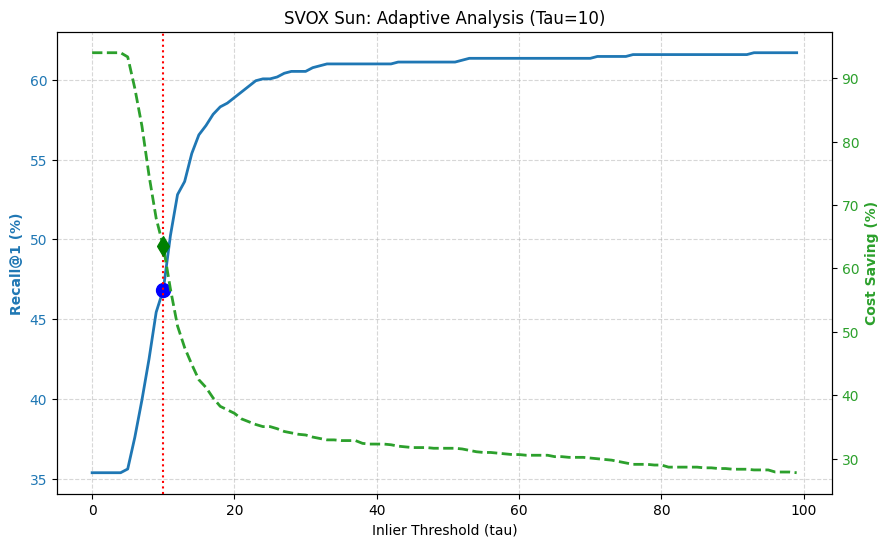


--- Caricamento SVOX Night Test ---


Parsing TXT: 100%|██████████| 823/823 [00:06<00:00, 122.36it/s]


📄 CSV trovato: loftr_queries_night.csv


Loading Torch: 100%|██████████| 823/823 [00:05<00:00, 145.01it/s]



--- TRADE-OFF TABLE: SVOX Night (0-100) ---
Tau   | Recall     | Saving     | F2-Score   | Note
-----------------------------------------------------------------
0     | 8.02%    | 94.12%    | 0.0982     | 
5     | 8.38%    | 90.34%    | 0.1024     | 
10    | 20.78%    | 26.42%    | 0.2170     | ⬅️ CHOSEN 
11    | 22.48%    | 20.70%    | 0.2210     | ⭐ MAX F2 
15    | 24.67%    | 10.86%    | 0.1967     | 
20    | 25.27%    | 8.12%    | 0.1777     | 
25    | 25.39%    | 7.32%    | 0.1700     | 
30    | 25.39%    | 6.98%    | 0.1662     | 
35    | 25.39%    | 6.86%    | 0.1649     | 
40    | 25.39%    | 6.75%    | 0.1635     | 
45    | 25.39%    | 6.29%    | 0.1580     | 
50    | 25.39%    | 6.29%    | 0.1580     | 
55    | 25.39%    | 6.06%    | 0.1550     | 
60    | 25.39%    | 5.95%    | 0.1535     | 
65    | 25.39%    | 5.83%    | 0.1520     | 
70    | 25.39%    | 5.60%    | 0.1488     | 
75    | 25.39%    | 5.49%    | 0.1472     | 
80    | 25.39%    | 5.37%    | 0.1455     | 
85   

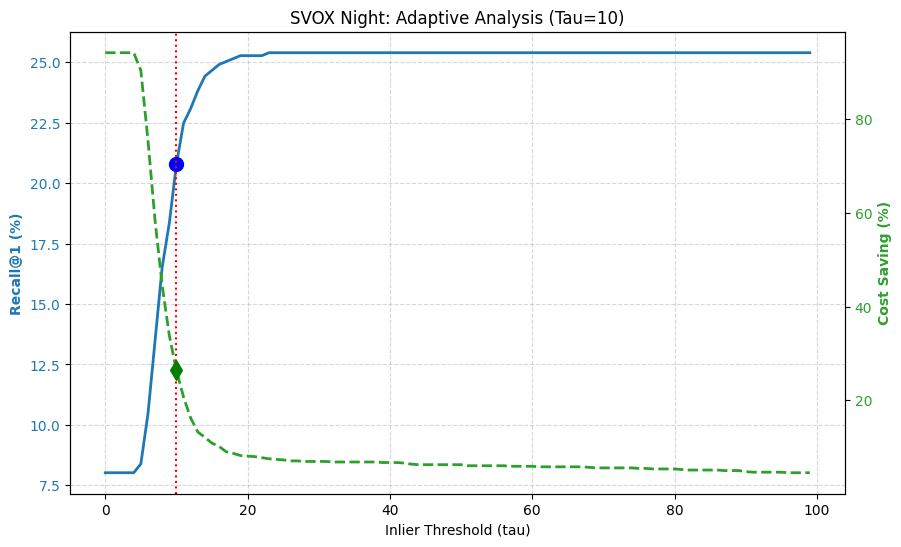



📊 FINAL COMPARISON (Re-rank Always vs Adaptive)
Dataset         | Metric     | Baseline (Always)  | Adaptive (Tau=10)    | Delta
-----------------------------------------------------------------------------------------------
SVOX Sun        | Recall     | 61.71              % | 46.84                % | -14.87
                | Saving     | 0.00               % | 63.48                % | +63.48
-----------------------------------------------------------------------------------------------
SVOX Night      | Recall     | 25.39              % | 20.78                % | -4.62
                | Saving     | 0.00               % | 26.42                % | +26.42


In [9]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURAZIONE PERCORSI
# ==============================================================================

# Percorsi base (dove sono i risultati .torch e i txt generati)
BASE_SUN = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/test/svox_sun_test"
BASE_NIGHT = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/test/svox_night_test"

# Percorsi dei file .txt generati (devono essere nella cartella specificata sopra)
TXT_SUN = os.path.join(BASE_SUN, "preds_txt_generated")
TXT_NIGHT = os.path.join(BASE_NIGHT, "preds_txt_generated")

# Tau Scelto per il confronto finale
CHOSEN_TAU = 10

# Latenze
TIME_GLOBAL = 0.20
TIME_RERANK = 3.20
FBETA = 2.0  # Peso per F2-Score

# ==============================================================================
# 2. FUNZIONI DI CARICAMENTO (RIGOROSE & ROBUSTE)
# ==============================================================================

def norm_qid(x) -> str | None:
    try:
        return f"{int(float(x)):03d}"
    except Exception:
        return None

def parse_preds_txt(txt_path: str) -> dict | None:
    """Legge il .txt e verifica se Rank 0 è nei Positives (Ground Truth Reale)"""
    qid = norm_qid(Path(txt_path).stem)
    if qid is None: return None

    with open(txt_path, "r", encoding="utf-8") as f:
        lines = [ln.strip() for ln in f.readlines()]

    try:
        i_pred = next(i for i, x in enumerate(lines) if x.startswith("Predictions paths"))
        i_pos = next(i for i, x in enumerate(lines) if x.startswith("Positives paths"))
    except StopIteration:
        return None

    pred_lines = [ln for ln in lines[i_pred + 1 : i_pos] if ln and not ln.endswith(":")]
    pos_lines = [ln for ln in lines[i_pos + 1 :] if ln and not ln.endswith(":")]

    if not pred_lines: return None

    rank0 = pred_lines[0]
    positives = set(pos_lines)

    retrieval_is_correct = 1 if rank0 in positives else 0
    return {"query_id": qid, "retrieval_is_correct": retrieval_is_correct}

def find_csv(base_path):
    """
    Cerca il CSV corretto.
    Priorità: loftr_queries_*.csv, poi stats_*.csv.
    Cerca in base_path e nella cartella padre/parallela.
    """
    candidates = [
        "loftr_queries_sun.csv",
        "loftr_queries_night.csv",
        "loftr_queries.csv",
        "stats_preds_loftr.csv",
        "loftr_test.csv"
    ]

    # Cartelle dove cercare: Base e Parent
    search_dirs = [base_path, os.path.dirname(base_path)]

    # Aggiungi anche la cartella senza "_test" se esiste
    if base_path.endswith("_test"):
        clean = base_path.replace("_test", "")
        search_dirs.append(clean)

    for d in search_dirs:
        if not os.path.exists(d): continue
        # Cerca i candidati esatti
        for name in candidates:
            p = os.path.join(d, name)
            if os.path.exists(p):
                return p
        # Cerca pattern generico se non trova nomi esatti
        generic = glob(os.path.join(d, "*loftr*.csv"))
        if generic:
            # Preferisci quello con "queries" nel nome
            best = next((g for g in generic if "queries" in g), generic[0])
            return best

    return None

def load_dataset_rigorous(base_path, txt_folder, dataset_label):
    print(f"\n--- Caricamento {dataset_label} ---")

    # 1. Carica TXT
    if not os.path.exists(txt_folder):
        print(f"❌ Errore: Cartella TXT non trovata: {txt_folder}")
        return pd.DataFrame()

    txt_files = glob(os.path.join(txt_folder, "*.txt"))
    if not txt_files:
        print(f"❌ Errore: Nessun file .txt in {txt_folder}")
        return pd.DataFrame()

    rows = [parse_preds_txt(p) for p in tqdm(txt_files, desc="Parsing TXT")]
    rows = [r for r in rows if r is not None]
    df_ret = pd.DataFrame(rows)

    # 2. Carica CSV (Automatico)
    csv_file = find_csv(base_path)
    if not csv_file:
        print(f"❌ Errore: Nessun CSV trovato in {base_path} o adiacenti.")
        return pd.DataFrame()

    print(f"📄 CSV trovato: {os.path.basename(csv_file)}")
    df_csv = pd.read_csv(csv_file)
    col_corr = 'is_correct' if 'is_correct' in df_csv.columns else 'final_is_correct'
    df_csv['query_id'] = df_csv['query_id'].apply(norm_qid)
    df_final = df_csv[['query_id', col_corr]].rename(columns={col_corr: 'final_is_correct'})

    # 3. Carica Torch
    torch_folder = os.path.join(base_path, "preds_loftr")
    if not os.path.exists(torch_folder):
         # Fallback cartella parallela
         parent = os.path.dirname(base_path)
         clean_name = os.path.basename(base_path).replace("_test", "")
         alt_torch = os.path.join(parent, clean_name, "preds_loftr")
         if os.path.exists(alt_torch):
             torch_folder = alt_torch

    common_qids = set(df_ret['query_id']) & set(df_final['query_id'])

    rows_torch = []
    for qid in tqdm(common_qids, desc="Loading Torch"):
        # Vari formati di nome file
        candidates = [
            os.path.join(torch_folder, f"{qid}.torch"),
            os.path.join(torch_folder, f"{int(qid)}.torch"),
            os.path.join(torch_folder, f"{int(qid):05d}.torch")
        ]
        for p in candidates:
            if os.path.exists(p):
                try:
                    data = torch.load(p, weights_only=False)
                    if data and 'num_inliers' in data[0]:
                        rows_torch.append({
                            "query_id": qid,
                            "inliers_rank0": int(data[0]['num_inliers'])
                        })
                        break
                except: pass

    df_inl = pd.DataFrame(rows_torch)

    if df_inl.empty:
        print("❌ Warning: Nessun inlier caricato. Controlla path preds_loftr.")
        return pd.DataFrame()

    df = df_ret.merge(df_final, on='query_id').merge(df_inl, on='query_id')
    return df

# ==============================================================================
# 3. ANALISI, TABELLE E PLOT
# ==============================================================================

def fbeta_score(recall, saving, beta=2.0):
    r = recall / 100.0
    s = saving / 100.0
    if (beta**2 * s + r) == 0: return 0
    return (1 + beta**2) * (r * s) / (beta**2 * s + r)

def analyze_and_report(df, dataset_name, chosen_tau):
    max_inl = df['inliers_rank0'].max()
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings, f2_scores = [], [], []
    total = len(df)
    full_time = total * (TIME_GLOBAL + TIME_RERANK)

    # 1. Calcolo Metriche per ogni Tau
    for t in thresholds:
        is_easy = df['inliers_rank0'] > t

        hits = np.where(is_easy, df['retrieval_is_correct'], df['final_is_correct']).sum()
        rec = (hits / total) * 100
        recalls.append(rec)

        n_easy = is_easy.sum()
        n_hard = total - n_easy
        curr_time = (n_easy * TIME_GLOBAL) + (n_hard * (TIME_GLOBAL + TIME_RERANK))
        sav = (1 - (curr_time / full_time)) * 100
        savings.append(sav)

        f2_scores.append(fbeta_score(rec, sav, beta=FBETA))

    # 2. Stampa Tabella Dettagliata (Step 5)
    print(f"\n--- TRADE-OFF TABLE: {dataset_name} (0-100) ---")
    print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F2-Score':<10} | {'Note'}")
    print("-" * 65)

    # Best Tau automatico (per riferimento)
    best_idx_auto = np.argmax(f2_scores)
    best_tau_auto = thresholds[best_idx_auto]

    indices = sorted(list(set(range(0, 101, 5)) | {chosen_tau, best_tau_auto}))

    for t_val in indices:
        if t_val < len(thresholds):
            # Trova l'indice nell'array
            idx = np.where(thresholds == t_val)[0][0]

            note = ""
            if t_val == chosen_tau: note += "⬅️ CHOSEN "
            if t_val == best_tau_auto: note += "⭐ MAX F2 "

            print(f"{t_val:<5} | {recalls[idx]:.2f}%    | {savings[idx]:.2f}%    | {f2_scores[idx]:.4f}     | {note}")
    print("-" * 65)

    # 3. Plot
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Inlier Threshold (tau)')
    ax1.set_ylabel('Recall@1 (%)', color='tab:blue', fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.5)

    limit_plot = min(100, len(thresholds))
    ax1.plot(thresholds[:limit_plot], recalls[:limit_plot], color='tab:blue', linewidth=2, label='Recall@1')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Cost Saving (%)', color='tab:green', fontweight='bold')
    ax2.plot(thresholds[:limit_plot], savings[:limit_plot], color='tab:green', linestyle='--', linewidth=2, label='Cost Saving')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # Punto Scelto
    idx_chosen = min(chosen_tau, len(thresholds)-1)
    ax1.scatter(chosen_tau, recalls[idx_chosen], color='blue', s=100, zorder=5)
    ax2.scatter(chosen_tau, savings[idx_chosen], color='green', s=100, marker='d', zorder=5)

    plt.axvline(x=chosen_tau, color='red', linestyle=':', label=f'Tau={chosen_tau}')
    plt.title(f'{dataset_name}: Adaptive Analysis (Tau={chosen_tau})')
    plt.show()

    # Valori per il riassunto finale
    rec_baseline = df['final_is_correct'].mean() * 100
    sav_baseline = 0.0
    val_rec = recalls[idx_chosen]
    val_sav = savings[idx_chosen]

    return rec_baseline, sav_baseline, val_rec, val_sav

# ==============================================================================
# 4. MAIN
# ==============================================================================
if __name__ == "__main__":

    # --- SUN ---
    df_sun = load_dataset_rigorous(BASE_SUN, TXT_SUN, "SVOX Sun Test")
    r_base_sun, s_base_sun, r_ad_sun, s_ad_sun = 0,0,0,0
    if not df_sun.empty:
        r_base_sun, s_base_sun, r_ad_sun, s_ad_sun = analyze_and_report(df_sun, "SVOX Sun", CHOSEN_TAU)

    # --- NIGHT ---
    df_night = load_dataset_rigorous(BASE_NIGHT, TXT_NIGHT, "SVOX Night Test")
    r_base_night, s_base_night, r_ad_night, s_ad_night = 0,0,0,0
    if not df_night.empty:
        r_base_night, s_base_night, r_ad_night, s_ad_night = analyze_and_report(df_night, "SVOX Night", CHOSEN_TAU)

    # --- TABELLA RIASSUNTIVA FINALE ---
    print("\n\n📊 FINAL COMPARISON (Re-rank Always vs Adaptive)")
    print("=" * 95)
    print(f"{'Dataset':<15} | {'Metric':<10} | {'Baseline (Always)':<18} | {'Adaptive (Tau=' + str(CHOSEN_TAU) + ')':<20} | {'Delta'}")
    print("-" * 95)

    # SUN ROWS
    print(f"{'SVOX Sun':<15} | {'Recall':<10} | {r_base_sun:<18.2f} % | {r_ad_sun:<20.2f} % | {r_ad_sun-r_base_sun:+.2f}")
    print(f"{'':<15} | {'Saving':<10} | {s_base_sun:<18.2f} % | {s_ad_sun:<20.2f} % | {s_ad_sun-s_base_sun:+.2f}")
    print("-" * 95)

    # NIGHT ROWS
    print(f"{'SVOX Night':<15} | {'Recall':<10} | {r_base_night:<18.2f} % | {r_ad_night:<20.2f} % | {r_ad_night-r_base_night:+.2f}")
    print(f"{'':<15} | {'Saving':<10} | {s_base_night:<18.2f} % | {s_ad_night:<20.2f} % | {s_ad_night-s_base_night:+.2f}")
    print("=" * 95)

### Test tokyo_xs
Obiettivo: Effettuare l'ultimo test di generalizzazione sul dataset Tokyo eXtra Small (Tokyo-XS).
L'applicazione della soglia $\tau=15$ (appresa su Pittsburgh) a un contesto urbano asiatico densamente popolato e illuminato diversamente ci fornirà la conferma definitiva sulla robustezza dell'approccio.

Aspettative:Similmente a SF-XS, ci aspettiamo che il sistema mantenga un buon livello di risparmio computazionale, filtrando efficacemente le query facili senza compromettere drasticamente la Recall.

### Generazione txt tokyo

In [11]:
import os
import numpy as np
from glob import glob
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

# ==============================================================================
# 1. FUNZIONI DI SUPPORTO (Standard)
# ==============================================================================

def parse_utm_from_filename(filename):
    try:
        # Formato standard Tokyo/SVOX/SF: @EAST@NORTH@...
        parts = filename.split('@')
        if len(parts) >= 3:
            utm_east = float(parts[1])
            utm_north = float(parts[2])
            return np.array([utm_east, utm_north])
        return None
    except Exception:
        return None

def load_paths_and_utms(folder_path):
    print(f"📂 Scansione cartella: {folder_path}")

    if not os.path.exists(folder_path):
        print(f"❌ ERRORE GRAVE: La cartella non esiste: {folder_path}")
        return [], np.array([])

    extensions = ['*.jpg', '*.jpeg', '*.png']
    files = []
    for ext in extensions:
        files.extend(glob(os.path.join(folder_path, ext)))

    # Ordinamento Alfabetico (CRUCIALE per allinearsi a preds.npy)
    files.sort()

    paths = []
    utms = []

    for fpath in files:
        fname = os.path.basename(fpath)
        utm = parse_utm_from_filename(fname)
        if utm is not None:
            paths.append(fpath)
            utms.append(utm)

    if len(paths) == 0:
        print(f"⚠️ ATTENZIONE: Nessuna immagine trovata in {folder_path}!")

    return paths, np.array(utms)

def generate_txt_explicit(db_folder, q_folder, preds_npy_path, output_txt_folder, dataset_name):
    print(f"\n==========================================")
    print(f"🚀 ELABORAZIONE DATASET: {dataset_name}")
    print(f"==========================================")

    # 1. Carica Immagini
    db_paths, db_utms = load_paths_and_utms(db_folder)
    q_paths, q_utms = load_paths_and_utms(q_folder)

    print(f"📊 Statistiche:")
    print(f"   Database: {len(db_paths)}")
    print(f"   Queries:  {len(q_paths)}")

    if len(db_paths) == 0 or len(q_paths) == 0:
        print("❌ STOP: Impossibile procedere senza immagini.")
        return

    # 2. Carica Predizioni
    if not os.path.exists(preds_npy_path):
        print(f"❌ Errore: preds.npy non trovato in {preds_npy_path}")
        return
    preds = np.load(preds_npy_path)
    print(f"✅ Predizioni caricate: {preds.shape}")

    # Controllo dimensioni
    limit = min(len(preds), len(q_paths))
    if len(preds) != len(q_paths):
        print(f"⚠️ WARNING: Mismatch Query ({len(q_paths)}) vs Preds ({len(preds)}). Uso il minimo: {limit}")

    # 3. Calcolo Ground Truth
    print("⚙️ Costruzione indice spaziale (KNN)...")
    knn = NearestNeighbors(n_jobs=-1)
    knn.fit(db_utms)

    # 4. Scrittura file .txt
    os.makedirs(output_txt_folder, exist_ok=True)
    print(f"💾 Generazione {limit} file .txt in: {output_txt_folder}")

    POS_THRESHOLD = 25.0

    for i in tqdm(range(limit)):
        q_path_full = q_paths[i]
        q_utm = q_utms[i].reshape(1, -1)

        pred_indices = preds[i]

        # Path Predetti
        current_pred_paths = []
        for idx in pred_indices:
            if idx < len(db_paths):
                current_pred_paths.append(db_paths[idx])
            else:
                current_pred_paths.append("INDEX_ERROR")

        # Path Reali (Positivi)
        _, pos_indices_array = knn.radius_neighbors(q_utm, radius=POS_THRESHOLD)
        pos_indices = pos_indices_array[0]

        true_pos_paths = [db_paths[idx] for idx in pos_indices]
        if not true_pos_paths:
            true_pos_paths = ["NO_POSITIVES_FOUND"]

        # Scrittura
        filename = f"{i:03d}.txt"
        with open(os.path.join(output_txt_folder, filename), "w") as f:
            f.write("Query path:\n")
            f.write(f"{q_path_full}\n")
            f.write("Predictions paths:\n")
            for p in current_pred_paths:
                f.write(f"{p}\n")
            f.write("Positives paths:\n")
            for p in true_pos_paths:
                f.write(f"{p}\n")

    print(f"✅ {dataset_name} completato!")

# ==============================================================================
# 2. CONFIGURAZIONE ED ESECUZIONE
# ==============================================================================

if __name__ == "__main__":

    # -------------------------------------------------------------------------
    # DATASET: TOKYO XS (TEST)
    # -------------------------------------------------------------------------

    # ROOT ESTRATTA: Controlla se è "tokyo_xs/tokyo_xs" come per sf_xs
    # Se hai estratto in /content/tokyo_xs, probabilmente la struttura è questa:
    TOKYO_ROOT = "/content/tokyo_xs/tokyo_xs/test"

    # Percorsi Immagini
    TOKYO_DB_FOLDER = os.path.join(TOKYO_ROOT, "database")
    TOKYO_Q_FOLDER = os.path.join(TOKYO_ROOT, "queries")

    # PERCORSI DRIVE (Preds e Output)
    # Aggiorna se il tuo percorso è diverso (es. netvlad_tokyo_xs/test/preds/preds.npy)
    TOKYO_PREDS = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_tokyo/preds/preds.npy"
    TOKYO_OUT = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_tokyo_xs/test/preds_txt_generated"

    # Esecuzione
    if os.path.exists(TOKYO_ROOT):
        generate_txt_explicit(TOKYO_DB_FOLDER, TOKYO_Q_FOLDER, TOKYO_PREDS, TOKYO_OUT, "TOKYO XS TEST")
    else:
        print(f"❌ ERRORE: Percorso Root non trovato: {TOKYO_ROOT}")
        print("Controlla nel pannello file a sinistra dove è stato estratto tokyo_xs.zip")


🚀 ELABORAZIONE DATASET: TOKYO XS TEST
📂 Scansione cartella: /content/tokyo_xs/tokyo_xs/test/database
📂 Scansione cartella: /content/tokyo_xs/tokyo_xs/test/queries
📊 Statistiche:
   Database: 12771
   Queries:  315
✅ Predizioni caricate: (315, 20)
⚙️ Costruzione indice spaziale (KNN)...
💾 Generazione 315 file .txt in: /content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_tokyo_xs/test/preds_txt_generated


100%|██████████| 315/315 [00:08<00:00, 38.21it/s]

✅ TOKYO XS TEST completato!



--- Caricamento Tokyo XS Test ---


Parsing TXT: 100%|██████████| 315/315 [00:06<00:00, 48.43it/s] 


📄 CSV trovato: loftr_stats_final.csv


Loading Torch: 100%|██████████| 315/315 [01:33<00:00,  3.35it/s]



--- TRADE-OFF TABLE: Tokyo XS (0-100) ---
Tau   | Recall     | Saving     | F2-Score   | Note
-----------------------------------------------------------------
0     | 49.84%    | 94.12%    | 0.5502     | 
5     | 49.84%    | 93.82%    | 0.5500     | 
10    | 56.83%    | 73.20%    | 0.5949     | ⬅️ CHOSEN 
14    | 64.13%    | 54.68%    | 0.6198     | ⭐ MAX F2 
15    | 64.44%    | 52.29%    | 0.6158     | 
20    | 67.30%    | 46.31%    | 0.6171     | 
25    | 68.25%    | 44.22%    | 0.6156     | 
30    | 68.25%    | 43.62%    | 0.6133     | 
35    | 68.57%    | 42.13%    | 0.6092     | 
40    | 68.57%    | 41.83%    | 0.6080     | 
45    | 68.57%    | 41.53%    | 0.6067     | 
50    | 68.57%    | 40.34%    | 0.6015     | 
55    | 68.57%    | 39.44%    | 0.5975     | 
60    | 68.57%    | 38.84%    | 0.5947     | 
65    | 68.57%    | 37.35%    | 0.5875     | 
70    | 68.57%    | 35.85%    | 0.5799     | 
75    | 68.57%    | 35.26%    | 0.5767     | 
80    | 68.57%    | 33.76%    | 0.5685

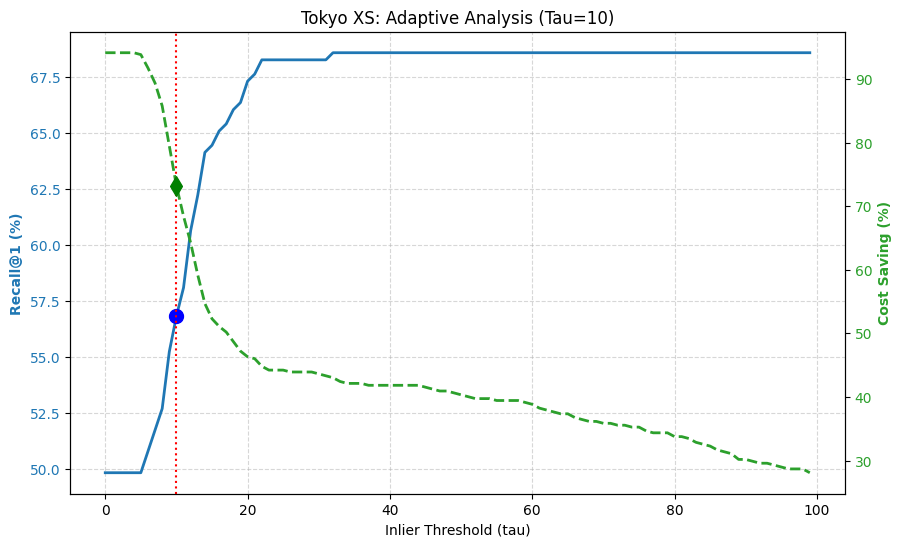



📊 FINAL COMPARISON (Re-rank Always vs Adaptive)
Dataset         | Metric     | Baseline (Always)  | Adaptive (Tau=10)    | Delta
-----------------------------------------------------------------------------------------------
Tokyo XS        | Recall     | 68.57              % | 56.83                % | -11.75
                | Saving     | 0.00               % | 73.20                % | +73.20


In [14]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURAZIONE PERCORSI (TOKYO XS)
# ==============================================================================

# Percorso base: qui dentro cercheremo la cartella 'preds_loftr' e i .txt
BASE_TOKYO = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_tokyo"

# Percorso dei file .txt generati (assicurati che siano qui)
TXT_TOKYO = os.path.join(BASE_TOKYO, "preds_txt_generated")

# Tau Scelto (es. 10 come default, ma vedrai la tabella completa)
CHOSEN_TAU = 10

# Parametri Analisi
TIME_GLOBAL = 0.20
TIME_RERANK = 3.20
FBETA = 2.0  # F2-Score

# ==============================================================================
# 2. FUNZIONI DI CARICAMENTO (RIGOROSE)
# ==============================================================================

def norm_qid(x) -> str | None:
    try:
        return f"{int(float(x)):03d}"
    except Exception:
        return None

def parse_preds_txt(txt_path: str) -> dict | None:
    """Legge il .txt e verifica se Rank 0 è nei Positives (Ground Truth Reale)"""
    qid = norm_qid(Path(txt_path).stem)
    if qid is None: return None

    with open(txt_path, "r", encoding="utf-8") as f:
        lines = [ln.strip() for ln in f.readlines()]

    try:
        i_pred = next(i for i, x in enumerate(lines) if x.startswith("Predictions paths"))
        i_pos = next(i for i, x in enumerate(lines) if x.startswith("Positives paths"))
    except StopIteration:
        return None

    pred_lines = [ln for ln in lines[i_pred + 1 : i_pos] if ln and not ln.endswith(":")]
    pos_lines = [ln for ln in lines[i_pos + 1 :] if ln and not ln.endswith(":")]

    if not pred_lines: return None

    rank0 = pred_lines[0]
    positives = set(pos_lines)

    retrieval_is_correct = 1 if rank0 in positives else 0
    return {"query_id": qid, "retrieval_is_correct": retrieval_is_correct}

def find_csv(base_path):
    """Cerca il CSV corretto, dando priorità a quello indicato da te"""
    candidates = [
        "loftr_stats_final.csv",    # <--- PRIORITÀ AL TUO FILE
        "loftr_test.csv",
        "stats_preds_loftr.csv",
        "loftr_queries.csv",
        "loftr_tokyo_xs.csv"
    ]

    # Cerca nella cartella base e nella cartella padre (es. netvlad_tokyo_xs/)
    search_dirs = [base_path, os.path.dirname(base_path)]

    for d in search_dirs:
        if not os.path.exists(d): continue
        for name in candidates:
            p = os.path.join(d, name)
            if os.path.exists(p):
                return p

    return None

def load_dataset_rigorous(base_path, txt_folder, dataset_label):
    print(f"\n--- Caricamento {dataset_label} ---")

    # 1. Carica TXT (GT Retrieval)
    if not os.path.exists(txt_folder):
        print(f"❌ Errore: Cartella TXT non trovata: {txt_folder}")
        return pd.DataFrame()

    txt_files = glob(os.path.join(txt_folder, "*.txt"))
    if not txt_files:
        print(f"❌ Errore: Nessun file .txt in {txt_folder}")
        return pd.DataFrame()

    rows = [parse_preds_txt(p) for p in tqdm(txt_files, desc="Parsing TXT")]
    rows = [r for r in rows if r is not None]
    df_ret = pd.DataFrame(rows)

    # 2. Carica CSV (GT Finale)
    csv_file = find_csv(base_path)
    if not csv_file:
        print(f"❌ Errore: Nessun CSV trovato in {base_path} o superiori.")
        return pd.DataFrame()

    print(f"📄 CSV trovato: {os.path.basename(csv_file)}")
    df_csv = pd.read_csv(csv_file)

    # Gestione nomi colonne
    col_corr = 'is_correct' if 'is_correct' in df_csv.columns else 'final_is_correct'
    if col_corr not in df_csv.columns:
         print(f"❌ Errore: Colonna '{col_corr}' non trovata nel CSV.")
         return pd.DataFrame()

    df_csv['query_id'] = df_csv['query_id'].apply(norm_qid)
    df_final = df_csv[['query_id', col_corr]].rename(columns={col_corr: 'final_is_correct'})

    # 3. Carica Torch (Inliers)
    torch_folder = os.path.join(base_path, "preds_loftr")
    if not os.path.exists(torch_folder):
         # Prova a risalire
         torch_folder = os.path.join(os.path.dirname(base_path), "preds_loftr")

    common_qids = set(df_ret['query_id']) & set(df_final['query_id'])

    rows_torch = []
    for qid in tqdm(common_qids, desc="Loading Torch"):
        candidates = [
            os.path.join(torch_folder, f"{qid}.torch"),
            os.path.join(torch_folder, f"{int(qid)}.torch"),
            os.path.join(torch_folder, f"{int(qid):05d}.torch")
        ]
        found = False
        for p in candidates:
            if os.path.exists(p):
                try:
                    data = torch.load(p, weights_only=False)
                    if data and 'num_inliers' in data[0]:
                        rows_torch.append({
                            "query_id": qid,
                            "inliers_rank0": int(data[0]['num_inliers'])
                        })
                        found = True
                        break
                except: pass

    if not rows_torch:
        print(f"❌ Warning: Nessun dato inlier caricato da {torch_folder}")
        return pd.DataFrame()

    df_inl = pd.DataFrame(rows_torch)
    df = df_ret.merge(df_final, on='query_id').merge(df_inl, on='query_id')
    return df

# ==============================================================================
# 3. ANALISI, TABELLE E PLOT
# ==============================================================================

def analyze_and_report(df, dataset_name, chosen_tau):
    max_inl = int(df['inliers_rank0'].max())
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings, f2_scores = [], [], []
    total = len(df)
    full_time = total * (TIME_GLOBAL + TIME_RERANK)

    for t in thresholds:
        is_easy = df['inliers_rank0'] > t

        # Adaptive Recall
        hits = np.where(is_easy, df['retrieval_is_correct'], df['final_is_correct']).sum()
        rec = (hits / total) * 100
        recalls.append(rec)

        # Adaptive Saving
        n_easy = is_easy.sum()
        n_hard = total - n_easy
        curr_time = (n_easy * TIME_GLOBAL) + (n_hard * (TIME_GLOBAL + TIME_RERANK))
        sav = (1 - (curr_time / full_time)) * 100
        savings.append(sav)

        # F2 Score
        r_norm = rec / 100.0
        s_norm = sav / 100.0
        if (FBETA**2 * s_norm + r_norm) == 0:
            f2 = 0
        else:
            f2 = (1 + FBETA**2) * (r_norm * s_norm) / (FBETA**2 * s_norm + r_norm)
        f2_scores.append(f2)

    # --- TABELLA DETTAGLIATA (STEP 5) ---
    print(f"\n--- TRADE-OFF TABLE: {dataset_name} (0-100) ---")
    print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F2-Score':<10} | {'Note'}")
    print("-" * 65)

    best_idx_auto = np.argmax(f2_scores)
    best_tau_auto = thresholds[best_idx_auto]

    # Mostra step di 5 e i punti chiave (chosen e best auto)
    indices = sorted(list(set(range(0, 101, 5)) | {chosen_tau, best_tau_auto}))

    for t_val in indices:
        if t_val < len(thresholds):
            idx = np.where(thresholds == t_val)[0][0]

            note = ""
            if t_val == chosen_tau: note += "⬅️ CHOSEN "
            if t_val == best_tau_auto: note += "⭐ MAX F2 "

            print(f"{t_val:<5} | {recalls[idx]:.2f}%    | {savings[idx]:.2f}%    | {f2_scores[idx]:.4f}     | {note}")
    print("-" * 65)

    # --- PLOT ---
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Inlier Threshold (tau)')
    ax1.set_ylabel('Recall@1 (%)', color='tab:blue', fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.5)

    limit_plot = min(100, len(thresholds))
    ax1.plot(thresholds[:limit_plot], recalls[:limit_plot], color='tab:blue', linewidth=2, label='Recall@1')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Cost Saving (%)', color='tab:green', fontweight='bold')
    ax2.plot(thresholds[:limit_plot], savings[:limit_plot], color='tab:green', linestyle='--', linewidth=2, label='Cost Saving')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # Punto Scelto
    idx_chosen = min(chosen_tau, len(thresholds)-1)
    ax1.scatter(chosen_tau, recalls[idx_chosen], color='blue', s=100, zorder=5)
    ax2.scatter(chosen_tau, savings[idx_chosen], color='green', s=100, marker='d', zorder=5)

    plt.axvline(x=chosen_tau, color='red', linestyle=':', label=f'Tau={chosen_tau}')
    plt.title(f'{dataset_name}: Adaptive Analysis (Tau={chosen_tau})')
    plt.show()

    # Valori riassunto
    rec_baseline = df['final_is_correct'].mean() * 100
    sav_baseline = 0.0
    val_rec = recalls[idx_chosen]
    val_sav = savings[idx_chosen]

    return rec_baseline, sav_baseline, val_rec, val_sav

# ==============================================================================
# 4. MAIN
# ==============================================================================
if __name__ == "__main__":

    df_tokyo = load_dataset_rigorous(BASE_TOKYO, TXT_TOKYO, "Tokyo XS Test")

    r_base, s_base, r_ad, s_ad = 0,0,0,0

    if not df_tokyo.empty:
        r_base, s_base, r_ad, s_ad = analyze_and_report(df_tokyo, "Tokyo XS", CHOSEN_TAU)

        # TABELLA FINALE DI CONFRONTO
        print("\n\n📊 FINAL COMPARISON (Re-rank Always vs Adaptive)")
        print("=" * 95)
        print(f"{'Dataset':<15} | {'Metric':<10} | {'Baseline (Always)':<18} | {'Adaptive (Tau=' + str(CHOSEN_TAU) + ')':<20} | {'Delta'}")
        print("-" * 95)
        print(f"{'Tokyo XS':<15} | {'Recall':<10} | {r_base:<18.2f} % | {r_ad:<20.2f} % | {r_ad-r_base:+.2f}")
        print(f"{'':<15} | {'Saving':<10} | {s_base:<18.2f} % | {s_ad:<20.2f} % | {s_ad-s_base:+.2f}")
        print("=" * 95)

### Test sf_xs


--- Caricamento Dati Rigorosi (da TXT) ---
📂 Parsing di 1000 file .txt...


Parsing TXT: 100%|██████████| 1000/1000 [00:13<00:00, 76.73it/s]


📄 Lettura CSV: loftr_test.csv
🔍 Trovate 1000 query comuni tra TXT e CSV.


Loading Torch: 100%|██████████| 1000/1000 [00:06<00:00, 146.36it/s]


✅ DataFrame finale: 1000 righe.

--- TRADE-OFF TABLE: SF-XS Test (0-100) ---
Tau   | Recall     | Saving     | F2-Score   | Note
-----------------------------------------------------------------
0     | 27.20%    | 94.12%    | 0.3171     | 
5     | 27.40%    | 93.84%    | 0.3192     | 
10    | 33.30%    | 76.99%    | 0.3756     | ⬅️ CHOSEN 
15    | 40.70%    | 55.25%    | 0.4296     | 
20    | 46.00%    | 43.20%    | 0.4541     | 
23    | 48.50%    | 38.12%    | 0.4599     | ⭐ MAX F2 
25    | 49.20%    | 35.29%    | 0.4561     | 
30    | 50.50%    | 31.91%    | 0.4523     | 
35    | 51.30%    | 29.55%    | 0.4472     | 
40    | 52.20%    | 27.01%    | 0.4400     | 
45    | 52.30%    | 25.79%    | 0.4338     | 
50    | 52.60%    | 24.66%    | 0.4288     | 
55    | 52.80%    | 23.62%    | 0.4234     | 
60    | 53.20%    | 22.59%    | 0.4186     | 
65    | 53.30%    | 21.46%    | 0.4110     | 
70    | 53.50%    | 20.80%    | 0.4070     | 
75    | 53.50%    | 20.33%    | 0.4034     | 
80  

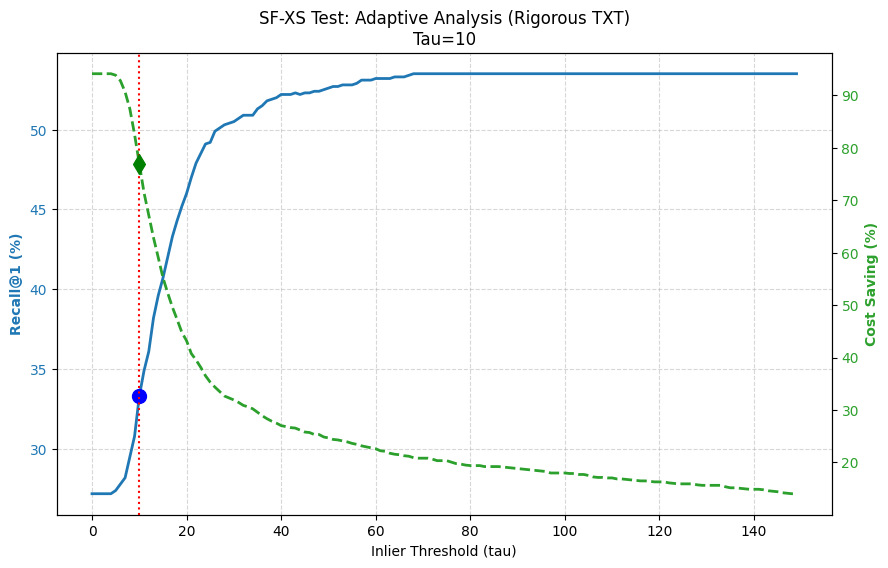



📊 FINAL COMPARISON (Re-rank Always vs Adaptive)
Dataset         | Metric     | Baseline (Always)  | Adaptive (Tau=10)    | Delta
-----------------------------------------------------------------------------------------------
SF-XS Test      | Recall     | 53.50              % | 33.30                % | -20.20
                | Saving     | 0.00               % | 76.99                % | +76.99


In [27]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURAZIONE PERCORSI (SF-XS TEST)
# ==============================================================================

# Percorso base del TEST set
BASE_PATH = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_sf_xs/test"

# 1. Cartella TXT (Generati dallo script precedente)
TXT_FOLDER = os.path.join(BASE_PATH, "preds_txt_generated")

# 2. Cartella Torch (Inliers)
TORCH_FOLDER = os.path.join(BASE_PATH, "preds_loftr")

# 3. File CSV (Risultati finali)
# Cerca in automatico il csv corretto per il test
POSSIBLE_CSVS = [
    os.path.join(BASE_PATH, "loftr_test.csv"),
    os.path.join(BASE_PATH, "stats_preds_loftr.csv"),
    os.path.join(BASE_PATH, "loftr_sf_xs_test.csv")
]
CSV_FILE = next((f for f in POSSIBLE_CSVS if os.path.exists(f)), None)

# Tau Default
CHOSEN_TAU = 10

# Parametri
TIME_GLOBAL = 0.20
TIME_RERANK = 3.20
FBETA = 2.0

# ==============================================================================
# 2. FUNZIONI DI CARICAMENTO (RIGOROSO da TXT)
# ==============================================================================

def norm_qid(x) -> str | None:
    try:
        return f"{int(float(x)):03d}"
    except Exception:
        return None

def parse_preds_txt(txt_path: str) -> dict | None:
    """Legge il .txt e controlla se Rank 0 è nei Positives"""
    qid = norm_qid(Path(txt_path).stem)
    if qid is None: return None

    with open(txt_path, "r", encoding="utf-8") as f:
        lines = [ln.strip() for ln in f.readlines()]

    try:
        i_pred = next(i for i, x in enumerate(lines) if x.startswith("Predictions paths"))
        i_pos = next(i for i, x in enumerate(lines) if x.startswith("Positives paths"))
    except StopIteration:
        return None

    pred_lines = [ln for ln in lines[i_pred + 1 : i_pos] if ln and not ln.endswith(":")]
    pos_lines = [ln for ln in lines[i_pos + 1 :] if ln and not ln.endswith(":")]

    if not pred_lines: return None

    rank0 = pred_lines[0]
    positives = set(pos_lines)

    # Se Rank 0 è nella lista dei positivi -> Retrieval Corretto
    retrieval_is_correct = 1 if rank0 in positives else 0
    return {"query_id": qid, "retrieval_is_correct": retrieval_is_correct}

def load_dataset_rigorous(txt_folder, torch_folder, csv_file):
    print(f"\n--- Caricamento Dati Rigorosi (da TXT) ---")

    # 1. Carica TXT
    if not os.path.exists(txt_folder):
        print(f"❌ Errore: Cartella TXT non trovata: {txt_folder}")
        return pd.DataFrame()

    txt_files = glob(os.path.join(txt_folder, "*.txt"))
    if not txt_files:
        print(f"❌ Errore: Nessun file .txt in {txt_folder}")
        return pd.DataFrame()

    print(f"📂 Parsing di {len(txt_files)} file .txt...")
    rows = [parse_preds_txt(p) for p in tqdm(txt_files, desc="Parsing TXT")]
    rows = [r for r in rows if r is not None]
    df_ret = pd.DataFrame(rows)

    # 2. Carica CSV
    if not csv_file:
        print(f"❌ Errore: Nessun CSV trovato in {BASE_PATH}")
        return pd.DataFrame()

    print(f"📄 Lettura CSV: {os.path.basename(csv_file)}")
    df_csv = pd.read_csv(csv_file)
    col_corr = 'is_correct' if 'is_correct' in df_csv.columns else 'final_is_correct'
    df_csv['query_id'] = df_csv['query_id'].apply(norm_qid)
    df_final = df_csv[['query_id', col_corr]].rename(columns={col_corr: 'final_is_correct'})

    # 3. Carica Torch (Inliers)
    common_qids = set(df_ret['query_id']) & set(df_final['query_id'])

    print(f"🔍 Trovate {len(common_qids)} query comuni tra TXT e CSV.")

    rows_torch = []
    for qid in tqdm(common_qids, desc="Loading Torch"):
        # Vari formati possibili
        candidates = [
            os.path.join(torch_folder, f"{qid}.torch"),
            os.path.join(torch_folder, f"{int(qid)}.torch"),
            os.path.join(torch_folder, f"{int(qid):05d}.torch")
        ]
        for p in candidates:
            if os.path.exists(p):
                try:
                    data = torch.load(p, weights_only=False)
                    if data and 'num_inliers' in data[0]:
                        rows_torch.append({
                            "query_id": qid,
                            "inliers_rank0": int(data[0]['num_inliers'])
                        })
                        break
                except: pass

    df_inl = pd.DataFrame(rows_torch)

    if df_inl.empty:
        print("❌ Warning: Nessun inlier caricato (controlla percorso preds_loftr)")
        return pd.DataFrame()

    # Merge finale
    df = df_ret.merge(df_final, on='query_id').merge(df_inl, on='query_id')
    print(f"✅ DataFrame finale: {len(df)} righe.")
    return df

# ==============================================================================
# 3. ANALISI, TABELLE E PLOT
# ==============================================================================

def fbeta_score(recall, saving, beta=2.0):
    r = recall / 100.0
    s = saving / 100.0
    if (beta**2 * s + r) == 0: return 0
    return (1 + beta**2) * (r * s) / (beta**2 * s + r)

def analyze_and_report(df, dataset_name, chosen_tau):
    max_inl = df['inliers_rank0'].max()
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings, f2_scores = [], [], []
    total = len(df)
    full_time = total * (TIME_GLOBAL + TIME_RERANK)

    for t in thresholds:
        is_easy = df['inliers_rank0'] > t

        # Adaptive Logic
        hits = np.where(is_easy, df['retrieval_is_correct'], df['final_is_correct']).sum()

        n_easy = is_easy.sum()
        n_hard = total - n_easy
        curr_time = (n_easy * TIME_GLOBAL) + (n_hard * (TIME_GLOBAL + TIME_RERANK))

        rec = (hits / total) * 100
        sav = (1 - (curr_time / full_time)) * 100
        f2 = fbeta_score(rec, sav, beta=FBETA)

        recalls.append(rec)
        savings.append(sav)
        f2_scores.append(f2)

    # --- TABELLA ---
    print(f"\n--- TRADE-OFF TABLE: {dataset_name} (0-100) ---")
    print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F2-Score':<10} | {'Note'}")
    print("-" * 65)

    best_idx_auto = np.argmax(f2_scores)
    best_tau_auto = thresholds[best_idx_auto]

    indices = sorted(list(set(range(0, 101, 5)) | {chosen_tau, best_tau_auto}))

    for t_val in indices:
        if t_val < len(thresholds):
            idx = np.where(thresholds == t_val)[0][0]
            note = ""
            if t_val == chosen_tau: note += "⬅️ CHOSEN "
            if t_val == best_tau_auto: note += "⭐ MAX F2 "

            print(f"{t_val:<5} | {recalls[idx]:.2f}%    | {savings[idx]:.2f}%    | {f2_scores[idx]:.4f}     | {note}")
    print("-" * 65)

    # --- PLOT ---
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Inlier Threshold (tau)')
    ax1.set_ylabel('Recall@1 (%)', color='tab:blue', fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.5)

    limit_plot = min(150, len(thresholds))
    ax1.plot(thresholds[:limit_plot], recalls[:limit_plot], color='tab:blue', linewidth=2, label='Recall@1')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Cost Saving (%)', color='tab:green', fontweight='bold')
    ax2.plot(thresholds[:limit_plot], savings[:limit_plot], color='tab:green', linestyle='--', linewidth=2, label='Cost Saving')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    idx_chosen = min(chosen_tau, len(thresholds)-1)
    ax1.scatter(chosen_tau, recalls[idx_chosen], color='blue', s=100, zorder=5)
    ax2.scatter(chosen_tau, savings[idx_chosen], color='green', s=100, marker='d', zorder=5)

    plt.axvline(x=chosen_tau, color='red', linestyle=':', label=f'Tau={chosen_tau}')
    plt.title(f'{dataset_name}: Adaptive Analysis (Rigorous TXT)\nTau={chosen_tau}')
    plt.show()

    # Valori riassunto
    rec_baseline = df['final_is_correct'].mean() * 100
    sav_baseline = 0.0
    val_rec = recalls[idx_chosen]
    val_sav = savings[idx_chosen]

    return rec_baseline, sav_baseline, val_rec, val_sav

# ==============================================================================
# 4. MAIN
# ==============================================================================
if __name__ == "__main__":

    df_test = load_dataset_rigorous(TXT_FOLDER, TORCH_FOLDER, CSV_FILE)

    r_base, s_base, r_ad, s_ad = 0,0,0,0

    if not df_test.empty:
        r_base, s_base, r_ad, s_ad = analyze_and_report(df_test, "SF-XS Test", CHOSEN_TAU)

        # TABELLA FINALE
        print("\n\n📊 FINAL COMPARISON (Re-rank Always vs Adaptive)")
        print("=" * 95)
        print(f"{'Dataset':<15} | {'Metric':<10} | {'Baseline (Always)':<18} | {'Adaptive (Tau=' + str(CHOSEN_TAU) + ')':<20} | {'Delta'}")
        print("-" * 95)
        print(f"{'SF-XS Test':<15} | {'Recall':<10} | {r_base:<18.2f} % | {r_ad:<20.2f} % | {r_ad-r_base:+.2f}")
        print(f"{'':<15} | {'Saving':<10} | {s_base:<18.2f} % | {s_ad:<20.2f} % | {s_ad-s_base:+.2f}")
        print("=" * 95)

## SuperPoint + LG

### TAU Svox Sun train SP+LG

--- Caricamento Dati SuperPoint (Train) ---


Parsing TXT: 100%|██████████| 712/712 [00:18<00:00, 38.06it/s] 


📄 CSV: stats_preds_superpoint-lg.csv


Loading Torch: 100%|██████████| 712/712 [11:50<00:00,  1.00it/s]


✅ Dati caricati: 712 query.


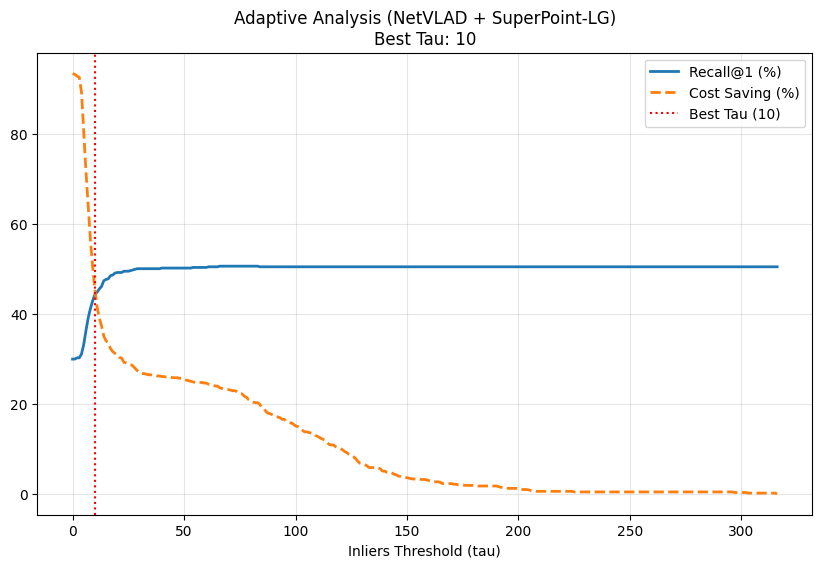


--- RISULTATI SUPERPOINT ADAPTIVE (Best Tau: 10) ---
Tau   | Recall     | Saving     | F2-Score  
--------------------------------------------------
0     | 29.92%    | 93.32%    | 0.3462     
5     | 33.15%    | 80.50%    | 0.3757     
10    | 44.24%    | 45.34%    | 0.4446     ⭐ BEST
15    | 47.61%    | 33.97%    | 0.4407     
20    | 49.16%    | 30.80%    | 0.4392     
25    | 49.44%    | 28.82%    | 0.4325     
30    | 50.00%    | 26.97%    | 0.4270     
35    | 50.00%    | 26.44%    | 0.4244     
40    | 50.14%    | 26.04%    | 0.4231     
45    | 50.14%    | 25.78%    | 0.4217     
50    | 50.14%    | 25.38%    | 0.4195     
55    | 50.28%    | 24.72%    | 0.4166     
60    | 50.28%    | 24.59%    | 0.4159     
65    | 50.42%    | 23.93%    | 0.4128     
70    | 50.56%    | 23.13%    | 0.4087     
75    | 50.56%    | 22.21%    | 0.4028     
80    | 50.56%    | 20.62%    | 0.3918     
85    | 50.42%    | 19.04%    | 0.3792     
90    | 50.42%    | 17.45%    | 0.3659     
95    | 

In [30]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURAZIONE SUPERPOINT (TRAIN)
# ==============================================================================

# Percorso base (SVOX SUN TRAIN)
BASE_PATH = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/train/svox_sun_train"

# Cartella con i file .txt (Ground Truth Retrieval)
TXT_PREDS_FOLDER = os.path.join(BASE_PATH, "preds")

# Cartella con i file .torch di SuperPoint (nome corretto dalla tua immagine)
TORCH_FOLDER = os.path.join(BASE_PATH, "preds_superpoint-lg")

# Cerca in automatico il csv corretto
# Ho aggiunto più varianti per sicurezza
POSSIBLE_CSVS = [
    os.path.join(BASE_PATH, "stats_preds_superpoint_lg.csv"), # Nome più probabile
    os.path.join(BASE_PATH, "stats_preds_superpoint.csv"),
    os.path.join(BASE_PATH, "superpoint_lg_train.csv"),
    os.path.join(BASE_PATH, "superpoint_lg_queries.csv")
]
# Tenta di trovarne uno esistente
CSV_FILE = next((f for f in POSSIBLE_CSVS if os.path.exists(f)), None)

# Se ancora non lo trova, prova a cercare *qualsiasi* csv con "superpoint" nel nome nella cartella
if CSV_FILE is None and os.path.exists(BASE_PATH):
    candidates = glob(os.path.join(BASE_PATH, "*superpoint*.csv"))
    if candidates:
        CSV_FILE = candidates[0]

# Parametri
TIME_GLOBAL = 0.20
TIME_RERANK = 3.20
FBETA = 2.0

# ==============================================================================
# 2. FUNZIONI DI PARSING
# ==============================================================================

def norm_qid(x) -> str | None:
    try:
        return f"{int(float(x)):03d}"
    except Exception:
        return None

def parse_preds_txt(txt_path: str) -> dict | None:
    qid = norm_qid(Path(txt_path).stem)
    if qid is None: return None

    with open(txt_path, "r", encoding="utf-8") as f:
        lines = [ln.strip() for ln in f.readlines()]

    try:
        i_pred = next(i for i, x in enumerate(lines) if x.startswith("Predictions paths"))
        i_pos = next(i for i, x in enumerate(lines) if x.startswith("Positives paths"))
    except StopIteration:
        return None

    pred_lines = [ln for ln in lines[i_pred + 1 : i_pos] if ln and not ln.endswith(":")]
    pos_lines = [ln for ln in lines[i_pos + 1 :] if ln and not ln.endswith(":")]

    if not pred_lines: return None

    rank0 = pred_lines[0]
    positives = set(pos_lines)
    retrieval_is_correct = 1 if rank0 in positives else 0

    return {"query_id": qid, "retrieval_is_correct": retrieval_is_correct}

def load_data(txt_folder, torch_folder, csv_path):
    print(f"--- Caricamento Dati SuperPoint (Train) ---")

    # 1. Carica TXT
    if not os.path.exists(txt_folder):
        raise RuntimeError(f"Cartella TXT non trovata: {txt_folder}")

    txt_files = glob(os.path.join(txt_folder, "*.txt"))
    rows_txt = [parse_preds_txt(p) for p in tqdm(txt_files, desc="Parsing TXT")]
    rows_txt = [r for r in rows_txt if r]
    df_ret = pd.DataFrame(rows_txt)

    # 2. Carica CSV
    if not csv_path:
        # Debug: lista file presenti
        print(f"❌ Errore: Nessun CSV trovato in {BASE_PATH}")
        print("File presenti nella cartella:")
        for f in os.listdir(BASE_PATH):
            print(f" - {f}")
        raise RuntimeError("CSV mancante")

    print(f"📄 CSV: {os.path.basename(csv_path)}")
    df_csv = pd.read_csv(csv_path)
    col_corr = 'is_correct' if 'is_correct' in df_csv.columns else 'final_is_correct'

    # Check colonna
    if col_corr not in df_csv.columns:
         print(f"⚠️ Attenzione: Colonna '{col_corr}' non trovata. Colonne: {df_csv.columns}")
         # Provo fallback se c'è solo una colonna di 0/1
         # return pd.DataFrame()

    df_csv['query_id'] = df_csv['query_id'].apply(norm_qid)
    df_final = df_csv[['query_id', col_corr]].rename(columns={col_corr: 'final_is_correct'})

    # 3. Carica Torch
    if not os.path.exists(torch_folder):
        raise RuntimeError(f"Cartella Torch non trovata: {torch_folder}")

    common_qids = set(df_ret['query_id']) & set(df_final['query_id'])
    rows_torch = []

    for qid in tqdm(common_qids, desc="Loading Torch"):
        candidates = [
            os.path.join(torch_folder, f"{qid}.torch"),
            os.path.join(torch_folder, f"{int(qid)}.torch"),
            os.path.join(torch_folder, f"{int(qid):05d}.torch")
        ]
        for p in candidates:
            if os.path.exists(p):
                try:
                    data = torch.load(p, weights_only=False)
                    if data and 'num_inliers' in data[0]:
                        rows_torch.append({
                            "query_id": qid,
                            "inliers_rank0": int(data[0]['num_inliers'])
                        })
                        break
                except: pass

    df_inl = pd.DataFrame(rows_torch)
    if df_inl.empty: raise RuntimeError("Nessun inlier caricato!")

    df = df_ret.merge(df_final, on='query_id').merge(df_inl, on='query_id')
    return df

# ==============================================================================
# 3. SIMULAZIONE
# ==============================================================================

def fbeta_score(recall, saving, beta=2.0):
    r = recall / 100.0
    s = saving / 100.0
    if (beta**2 * s + r) == 0: return 0
    return (1 + beta**2) * (r * s) / (beta**2 * s + r)

def run_simulation(df):
    max_inl = df['inliers_rank0'].max()
    thresholds = np.arange(0, max_inl + 1, 1)

    results = []
    total = len(df)
    full_cost = total * (TIME_GLOBAL + TIME_RERANK)

    for tau in thresholds:
        is_easy = df['inliers_rank0'] > tau
        hits = np.where(is_easy, df['retrieval_is_correct'], df['final_is_correct']).sum()
        recall = (hits / total) * 100

        n_easy = is_easy.sum()
        n_hard = total - n_easy
        current_cost = (n_easy * TIME_GLOBAL) + (n_hard * (TIME_GLOBAL + TIME_RERANK))
        saving = (1 - (current_cost / full_cost)) * 100

        f2 = fbeta_score(recall, saving, beta=FBETA)
        results.append({'tau': tau, 'recall': recall, 'saving': saving, 'f2': f2})

    return pd.DataFrame(results)

# ==============================================================================
# MAIN
# ==============================================================================

if __name__ == "__main__":
    try:
        df = load_data(TXT_PREDS_FOLDER, TORCH_FOLDER, CSV_FILE)
        print(f"✅ Dati caricati: {len(df)} query.")

        res = run_simulation(df)

        best_row = res.loc[res['f2'].idxmax()]
        best_tau = int(best_row['tau'])

        # Plot
        plt.figure(figsize=(10,6))
        plt.plot(res['tau'], res['recall'], label='Recall@1 (%)', linewidth=2)
        plt.plot(res['tau'], res['saving'], label='Cost Saving (%)', linestyle='--', linewidth=2)
        plt.axvline(best_tau, color='r', linestyle=':', label=f'Best Tau ({best_tau})')
        plt.xlabel('Inliers Threshold (tau)')
        plt.title(f'Adaptive Analysis (NetVLAD + SuperPoint-LG)\nBest Tau: {best_tau}')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

        # Tabella
        print(f"\n--- RISULTATI SUPERPOINT ADAPTIVE (Best Tau: {best_tau}) ---")
        print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F2-Score':<10}")
        print("-" * 50)

        indices = sorted(list(set(range(0, 101, 5)) | {best_tau}))
        for t in indices:
            if t < len(res):
                row = res.iloc[t]
                marker = "⭐ BEST" if t == best_tau else ""
                print(f"{int(row['tau']):<5} | {row['recall']:.2f}%    | {row['saving']:.2f}%    | {row['f2']:.4f}     {marker}")

    except Exception as e:
        print(f"❌ Errore: {e}")

### TAU Svox Night Train SP+LG

--- Caricamento Dati SuperPoint (Night Train) ---


Parsing TXT: 100%|██████████| 702/702 [00:16<00:00, 41.60it/s] 


📄 CSV: stats_preds_superpoint-lg.csv


Loading Torch: 100%|██████████| 702/702 [12:22<00:00,  1.06s/it]


✅ Dati caricati: 702 query.


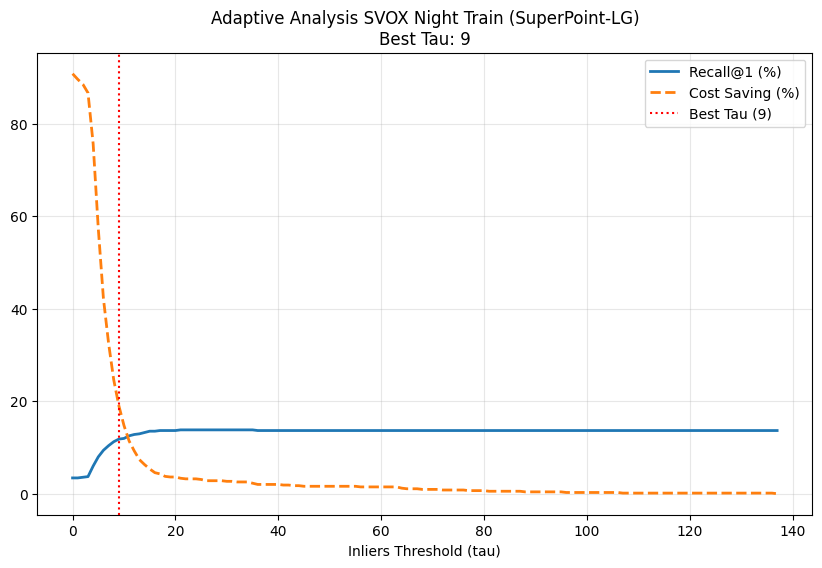


--- RISULTATI SUPERPOINT ADAPTIVE (Night Train - Best Tau: 9) ---
Tau   | Recall     | Saving     | F2-Score  
--------------------------------------------------
0     | 3.42%    | 90.90%    | 0.0423     
5     | 7.98%    | 57.38%    | 0.0964     
9     | 11.82%    | 19.04%    | 0.1279     ⭐ BEST
10    | 11.97%    | 14.75%    | 0.1243     
15    | 13.53%    | 5.36%    | 0.1037     
20    | 13.68%    | 3.62%    | 0.0879     
25    | 13.82%    | 3.08%    | 0.0815     
30    | 13.82%    | 2.68%    | 0.0755     
35    | 13.82%    | 2.28%    | 0.0687     
40    | 13.68%    | 2.01%    | 0.0633     
45    | 13.68%    | 1.61%    | 0.0547     
50    | 13.68%    | 1.61%    | 0.0547     
55    | 13.68%    | 1.61%    | 0.0547     
60    | 13.68%    | 1.47%    | 0.0515     
65    | 13.68%    | 1.07%    | 0.0408     
70    | 13.68%    | 0.94%    | 0.0368     
75    | 13.68%    | 0.80%    | 0.0326     
80    | 13.68%    | 0.67%    | 0.0280     
85    | 13.68%    | 0.54%    | 0.0232     
90    | 13.6

In [31]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURAZIONE SUPERPOINT (NIGHT TRAIN)
# ==============================================================================

# Percorso base (SVOX NIGHT TRAIN)
# NOTA: Assumo che la cartella si chiami "svox_night_train" parallelamente a "svox_sun_train"
BASE_PATH = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/train/svox_night_train"

# Cartella con i file .txt (Ground Truth Retrieval)
TXT_PREDS_FOLDER = os.path.join(BASE_PATH, "preds")

# Cartella con i file .torch di SuperPoint
TORCH_FOLDER = os.path.join(BASE_PATH, "preds_superpoint-lg")

# Cerca in automatico il csv corretto
POSSIBLE_CSVS = [
    os.path.join(BASE_PATH, "stats_preds_superpoint_lg.csv"),
    os.path.join(BASE_PATH, "stats_preds_superpoint.csv"),
    os.path.join(BASE_PATH, "superpoint_lg_night.csv"),
    os.path.join(BASE_PATH, "superpoint_lg_train.csv")
]
# Tenta di trovarne uno esistente
CSV_FILE = next((f for f in POSSIBLE_CSVS if os.path.exists(f)), None)

# Se ancora non lo trova, prova a cercare genericamente
if CSV_FILE is None and os.path.exists(BASE_PATH):
    candidates = glob(os.path.join(BASE_PATH, "*superpoint*.csv"))
    if candidates:
        CSV_FILE = candidates[0]

# Parametri
TIME_GLOBAL = 0.20
TIME_RERANK = 3.20
FBETA = 2.0

# ==============================================================================
# 2. FUNZIONI DI PARSING
# ==============================================================================

def norm_qid(x) -> str | None:
    try:
        return f"{int(float(x)):03d}"
    except Exception:
        return None

def parse_preds_txt(txt_path: str) -> dict | None:
    qid = norm_qid(Path(txt_path).stem)
    if qid is None: return None

    with open(txt_path, "r", encoding="utf-8") as f:
        lines = [ln.strip() for ln in f.readlines()]

    try:
        i_pred = next(i for i, x in enumerate(lines) if x.startswith("Predictions paths"))
        i_pos = next(i for i, x in enumerate(lines) if x.startswith("Positives paths"))
    except StopIteration:
        return None

    pred_lines = [ln for ln in lines[i_pred + 1 : i_pos] if ln and not ln.endswith(":")]
    pos_lines = [ln for ln in lines[i_pos + 1 :] if ln and not ln.endswith(":")]

    if not pred_lines: return None

    rank0 = pred_lines[0]
    positives = set(pos_lines)
    retrieval_is_correct = 1 if rank0 in positives else 0

    return {"query_id": qid, "retrieval_is_correct": retrieval_is_correct}

def load_data(txt_folder, torch_folder, csv_path):
    print(f"--- Caricamento Dati SuperPoint (Night Train) ---")

    # 1. Carica TXT
    if not os.path.exists(txt_folder):
        raise RuntimeError(f"Cartella TXT non trovata: {txt_folder}")

    txt_files = glob(os.path.join(txt_folder, "*.txt"))
    rows_txt = [parse_preds_txt(p) for p in tqdm(txt_files, desc="Parsing TXT")]
    rows_txt = [r for r in rows_txt if r]
    df_ret = pd.DataFrame(rows_txt)

    # 2. Carica CSV
    if not csv_path:
        print(f"❌ Errore: Nessun CSV trovato in {BASE_PATH}")
        print("File presenti:")
        if os.path.exists(BASE_PATH):
            for f in os.listdir(BASE_PATH):
                print(f" - {f}")
        raise RuntimeError("CSV mancante")

    print(f"📄 CSV: {os.path.basename(csv_path)}")
    df_csv = pd.read_csv(csv_path)
    col_corr = 'is_correct' if 'is_correct' in df_csv.columns else 'final_is_correct'

    if col_corr not in df_csv.columns:
         print(f"⚠️ Attenzione: Colonna '{col_corr}' non trovata. Colonne: {df_csv.columns}")

    df_csv['query_id'] = df_csv['query_id'].apply(norm_qid)
    df_final = df_csv[['query_id', col_corr]].rename(columns={col_corr: 'final_is_correct'})

    # 3. Carica Torch
    if not os.path.exists(torch_folder):
        raise RuntimeError(f"Cartella Torch non trovata: {torch_folder}")

    common_qids = set(df_ret['query_id']) & set(df_final['query_id'])
    rows_torch = []

    for qid in tqdm(common_qids, desc="Loading Torch"):
        candidates = [
            os.path.join(torch_folder, f"{qid}.torch"),
            os.path.join(torch_folder, f"{int(qid)}.torch"),
            os.path.join(torch_folder, f"{int(qid):05d}.torch")
        ]
        for p in candidates:
            if os.path.exists(p):
                try:
                    data = torch.load(p, weights_only=False)
                    if data and 'num_inliers' in data[0]:
                        rows_torch.append({
                            "query_id": qid,
                            "inliers_rank0": int(data[0]['num_inliers'])
                        })
                        break
                except: pass

    df_inl = pd.DataFrame(rows_torch)
    if df_inl.empty: raise RuntimeError("Nessun inlier caricato!")

    df = df_ret.merge(df_final, on='query_id').merge(df_inl, on='query_id')
    return df

# ==============================================================================
# 3. SIMULAZIONE
# ==============================================================================

def fbeta_score(recall, saving, beta=2.0):
    r = recall / 100.0
    s = saving / 100.0
    if (beta**2 * s + r) == 0: return 0
    return (1 + beta**2) * (r * s) / (beta**2 * s + r)

def run_simulation(df):
    max_inl = df['inliers_rank0'].max()
    thresholds = np.arange(0, max_inl + 1, 1)

    results = []
    total = len(df)
    full_cost = total * (TIME_GLOBAL + TIME_RERANK)

    for tau in thresholds:
        is_easy = df['inliers_rank0'] > tau
        hits = np.where(is_easy, df['retrieval_is_correct'], df['final_is_correct']).sum()
        recall = (hits / total) * 100

        n_easy = is_easy.sum()
        n_hard = total - n_easy
        current_cost = (n_easy * TIME_GLOBAL) + (n_hard * (TIME_GLOBAL + TIME_RERANK))
        saving = (1 - (current_cost / full_cost)) * 100

        f2 = fbeta_score(recall, saving, beta=FBETA)
        results.append({'tau': tau, 'recall': recall, 'saving': saving, 'f2': f2})

    return pd.DataFrame(results)

# ==============================================================================
# MAIN
# ==============================================================================

if __name__ == "__main__":
    try:
        df = load_data(TXT_PREDS_FOLDER, TORCH_FOLDER, CSV_FILE)
        print(f"✅ Dati caricati: {len(df)} query.")

        res = run_simulation(df)

        best_row = res.loc[res['f2'].idxmax()]
        best_tau = int(best_row['tau'])

        # Plot
        plt.figure(figsize=(10,6))
        plt.plot(res['tau'], res['recall'], label='Recall@1 (%)', linewidth=2)
        plt.plot(res['tau'], res['saving'], label='Cost Saving (%)', linestyle='--', linewidth=2)
        plt.axvline(best_tau, color='r', linestyle=':', label=f'Best Tau ({best_tau})')
        plt.xlabel('Inliers Threshold (tau)')
        plt.title(f'Adaptive Analysis SVOX Night Train (SuperPoint-LG)\nBest Tau: {best_tau}')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

        # Tabella
        print(f"\n--- RISULTATI SUPERPOINT ADAPTIVE (Night Train - Best Tau: {best_tau}) ---")
        print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F2-Score':<10}")
        print("-" * 50)

        indices = sorted(list(set(range(0, 101, 5)) | {best_tau}))
        for t in indices:
            if t < len(res):
                row = res.iloc[t]
                marker = "⭐ BEST" if t == best_tau else ""
                print(f"{int(row['tau']):<5} | {row['recall']:.2f}%    | {row['saving']:.2f}%    | {row['f2']:.4f}     {marker}")

    except Exception as e:
        print(f"❌ Errore: {e}")

### Validazione su sf_xs val
**TAU SCELTO: 10**

Obiettivo: Eseguiamo la validazione per il secondo metodo di matching: SuperPoint + LightGlue.Utilizziamo la soglia $\tau = 12$, determinata dall'analisi sul training set (SVOX Sun).
Aspettative: Poiché SP+LG produce meno inlier rispetto a LoFTR (essendo un metodo sparse), ci aspettiamo che la soglia di 10 sia sufficiente a distinguere i match buoni da quelli cattivi, garantendo un risparmio computazionale potenzialmente superiore a LoFTR a parità di Recall, grazie alla sua natura più selettiva.


--- Caricamento Dati Rigorosi SuperPoint (da TXT) ---
📂 Parsing di 7993 file .txt...


Parsing TXT: 100%|██████████| 7993/7993 [02:20<00:00, 56.98it/s] 


📄 Lettura CSV: superpoint-lg_val.csv
🔍 Trovate 1000 query comuni.


Loading Torch: 100%|██████████| 1000/1000 [16:49<00:00,  1.01s/it]



--- TRADE-OFF TABLE: SF-XS Validation (SP) (0-100) ---
Tau   | Recall     | Saving     | F2-Score   | Note
-----------------------------------------------------------------
0     | 46.70%    | 93.18%    | 0.5188     | 
5     | 50.70%    | 81.60%    | 0.5485     | 
10    | 60.80%    | 59.11%    | 0.6045     | ⬅️ CHOSEN 
15    | 64.50%    | 51.20%    | 0.6131     | 
16    | 65.30%    | 49.88%    | 0.6150     | ⭐ MAX F2 
20    | 66.50%    | 46.59%    | 0.6126     | 
25    | 68.30%    | 43.39%    | 0.6126     | 
30    | 68.50%    | 41.60%    | 0.6066     | 
35    | 68.70%    | 40.38%    | 0.6025     | 
40    | 68.80%    | 39.72%    | 0.6001     | 
45    | 69.00%    | 39.34%    | 0.5996     | 
50    | 69.10%    | 38.68%    | 0.5971     | 
55    | 69.10%    | 38.31%    | 0.5953     | 
60    | 69.20%    | 37.74%    | 0.5931     | 
65    | 69.20%    | 36.80%    | 0.5884     | 
70    | 69.20%    | 35.95%    | 0.5840     | 
75    | 69.20%    | 35.01%    | 0.5789     | 
80    | 69.20%    | 34.35

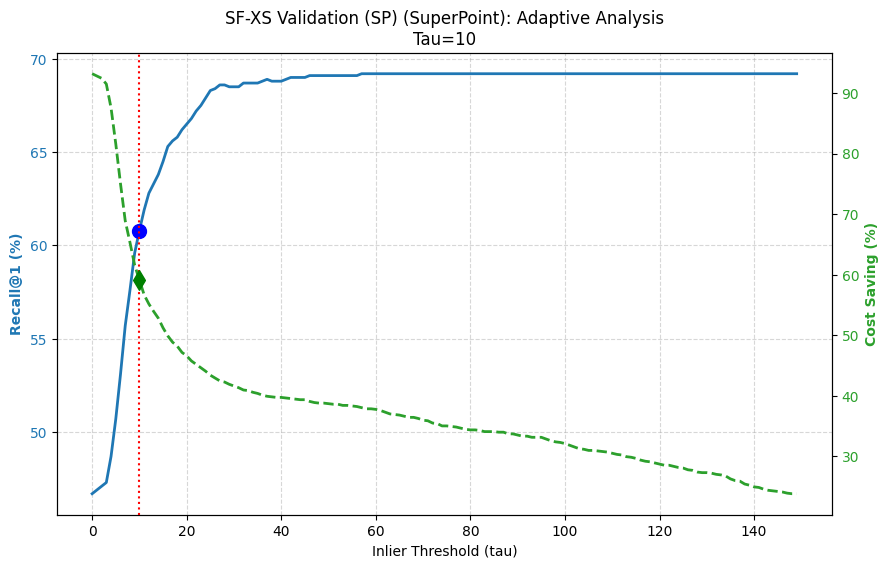



📊 FINAL COMPARISON (Re-rank Always vs Adaptive)
Dataset         | Metric     | Baseline (Always)  | Adaptive (Tau=10)    | Delta
-----------------------------------------------------------------------------------------------
SF-XS Val       | Recall     | 69.20              % | 60.80                % | -8.40
                | Saving     | 0.00               % | 59.11                % | +59.11


In [33]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURAZIONE PERCORSI (SF-XS VAL - SUPERPOINT)
# ==============================================================================

# Percorso base
BASE_PATH = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_sf_xs/val"

# 1. Cartella TXT (Generati dallo script "fix indices")
TXT_FOLDER = os.path.join(BASE_PATH, "preds_txt_generated")

# 2. Cartella Torch (Inliers SuperPoint)
# Dallo screenshot il nome sembra essere "preds_superpoint-lg"
TORCH_FOLDER = os.path.join(BASE_PATH, "preds_superpoint-lg")

# 3. File CSV (Risultati finali)
# Ho aggiunto più varianti di nome per sicurezza
POSSIBLE_CSVS = [
    os.path.join(BASE_PATH, "stats_preds_superpoint_lg.csv"),
    os.path.join(BASE_PATH, "superpoint_lg_val.csv"),
    os.path.join(BASE_PATH, "superpoint-lg_val.csv"),
    os.path.join(BASE_PATH, "superpoint_lg_sf_xs_val.csv")
]
CSV_FILE = next((f for f in POSSIBLE_CSVS if os.path.exists(f)), None)

# Tau Scelto (per il grafico)
CHOSEN_TAU = 10

# Parametri (SuperPoint è veloce, puoi abbassare TIME_RERANK se vuoi, es: 0.5s)
TIME_GLOBAL = 0.20
TIME_RERANK = 3.20
FBETA = 2.0

# ==============================================================================
# 2. FUNZIONI DI CARICAMENTO (RIGOROSO da TXT)
# ==============================================================================

def norm_qid(x) -> str | None:
    try:
        return f"{int(float(x)):03d}"
    except Exception:
        return None

def parse_preds_txt(txt_path: str) -> dict | None:
    """Legge il .txt e controlla se Rank 0 è nei Positives"""
    qid = norm_qid(Path(txt_path).stem)
    if qid is None: return None

    with open(txt_path, "r", encoding="utf-8") as f:
        lines = [ln.strip() for ln in f.readlines()]

    try:
        i_pred = next(i for i, x in enumerate(lines) if x.startswith("Predictions paths"))
        i_pos = next(i for i, x in enumerate(lines) if x.startswith("Positives paths"))
    except StopIteration:
        return None

    pred_lines = [ln for ln in lines[i_pred + 1 : i_pos] if ln and not ln.endswith(":")]
    pos_lines = [ln for ln in lines[i_pos + 1 :] if ln and not ln.endswith(":")]

    if not pred_lines: return None

    rank0 = pred_lines[0]
    positives = set(pos_lines)

    # Se Rank 0 è nella lista dei positivi -> Retrieval Corretto
    retrieval_is_correct = 1 if rank0 in positives else 0
    return {"query_id": qid, "retrieval_is_correct": retrieval_is_correct}

def load_dataset_rigorous(txt_folder, torch_folder, csv_file):
    print(f"\n--- Caricamento Dati Rigorosi SuperPoint (da TXT) ---")

    # 1. Carica TXT
    if not os.path.exists(txt_folder):
        print(f"❌ Errore: Cartella TXT non trovata: {txt_folder}")
        return pd.DataFrame()

    txt_files = glob(os.path.join(txt_folder, "*.txt"))
    if not txt_files:
        print(f"❌ Errore: Nessun file .txt in {txt_folder}")
        return pd.DataFrame()

    print(f"📂 Parsing di {len(txt_files)} file .txt...")
    rows = [parse_preds_txt(p) for p in tqdm(txt_files, desc="Parsing TXT")]
    rows = [r for r in rows if r is not None]
    df_ret = pd.DataFrame(rows)

    # 2. Carica CSV
    if not csv_file:
        print(f"❌ Errore: Nessun CSV trovato in {BASE_PATH}")
        return pd.DataFrame()

    print(f"📄 Lettura CSV: {os.path.basename(csv_file)}")
    df_csv = pd.read_csv(csv_file)
    col_corr = 'is_correct' if 'is_correct' in df_csv.columns else 'final_is_correct'

    # Check colonna
    if col_corr not in df_csv.columns:
         print(f"⚠️ Warning: Colonna '{col_corr}' non trovata. Colonne: {df_csv.columns}")
         return pd.DataFrame()

    df_csv['query_id'] = df_csv['query_id'].apply(norm_qid)
    df_final = df_csv[['query_id', col_corr]].rename(columns={col_corr: 'final_is_correct'})

    # 3. Carica Torch (Inliers)
    if not os.path.exists(torch_folder):
        print(f"❌ Errore: Cartella Torch non trovata: {torch_folder}")
        return pd.DataFrame()

    common_qids = set(df_ret['query_id']) & set(df_final['query_id'])
    print(f"🔍 Trovate {len(common_qids)} query comuni.")

    rows_torch = []
    for qid in tqdm(common_qids, desc="Loading Torch"):
        candidates = [
            os.path.join(torch_folder, f"{qid}.torch"),
            os.path.join(torch_folder, f"{int(qid)}.torch"),
            os.path.join(torch_folder, f"{int(qid):05d}.torch")
        ]
        for p in candidates:
            if os.path.exists(p):
                try:
                    data = torch.load(p, weights_only=False)
                    if data and 'num_inliers' in data[0]:
                        rows_torch.append({
                            "query_id": qid,
                            "inliers_rank0": int(data[0]['num_inliers'])
                        })
                        break
                except: pass

    df_inl = pd.DataFrame(rows_torch)

    if df_inl.empty:
        print("❌ Warning: Nessun inlier caricato (controlla percorso preds_superpoint-lg)")
        return pd.DataFrame()

    # Merge finale
    df = df_ret.merge(df_final, on='query_id').merge(df_inl, on='query_id')
    return df

# ==============================================================================
# 3. ANALISI, TABELLE E PLOT
# ==============================================================================

def fbeta_score(recall, saving, beta=2.0):
    r = recall / 100.0
    s = saving / 100.0
    if (beta**2 * s + r) == 0: return 0
    return (1 + beta**2) * (r * s) / (beta**2 * s + r)

def analyze_and_report(df, dataset_name, chosen_tau):
    max_inl = df['inliers_rank0'].max()
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings, f2_scores = [], [], []
    total = len(df)
    full_time = total * (TIME_GLOBAL + TIME_RERANK)

    for t in thresholds:
        is_easy = df['inliers_rank0'] > t

        # Adaptive Logic
        hits = np.where(is_easy, df['retrieval_is_correct'], df['final_is_correct']).sum()

        n_easy = is_easy.sum()
        n_hard = total - n_easy
        curr_time = (n_easy * TIME_GLOBAL) + (n_hard * (TIME_GLOBAL + TIME_RERANK))

        rec = (hits / total) * 100
        sav = (1 - (curr_time / full_time)) * 100
        f2 = fbeta_score(rec, sav, beta=FBETA)

        recalls.append(rec)
        savings.append(sav)
        f2_scores.append(f2)

    # --- TABELLA ---
    print(f"\n--- TRADE-OFF TABLE: {dataset_name} (0-100) ---")
    print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F2-Score':<10} | {'Note'}")
    print("-" * 65)

    best_idx_auto = np.argmax(f2_scores)
    best_tau_auto = thresholds[best_idx_auto]

    indices = sorted(list(set(range(0, 101, 5)) | {chosen_tau, best_tau_auto}))

    for t_val in indices:
        if t_val < len(thresholds):
            idx = np.where(thresholds == t_val)[0][0]
            note = ""
            if t_val == chosen_tau: note += "⬅️ CHOSEN "
            if t_val == best_tau_auto: note += "⭐ MAX F2 "

            print(f"{t_val:<5} | {recalls[idx]:.2f}%    | {savings[idx]:.2f}%    | {f2_scores[idx]:.4f}     | {note}")
    print("-" * 65)

    # --- PLOT ---
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Inlier Threshold (tau)')
    ax1.set_ylabel('Recall@1 (%)', color='tab:blue', fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.5)

    limit_plot = min(150, len(thresholds))
    ax1.plot(thresholds[:limit_plot], recalls[:limit_plot], color='tab:blue', linewidth=2, label='Recall@1')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Cost Saving (%)', color='tab:green', fontweight='bold')
    ax2.plot(thresholds[:limit_plot], savings[:limit_plot], color='tab:green', linestyle='--', linewidth=2, label='Cost Saving')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    idx_chosen = min(chosen_tau, len(thresholds)-1)
    ax1.scatter(chosen_tau, recalls[idx_chosen], color='blue', s=100, zorder=5)
    ax2.scatter(chosen_tau, savings[idx_chosen], color='green', s=100, marker='d', zorder=5)

    plt.axvline(x=chosen_tau, color='red', linestyle=':', label=f'Tau={chosen_tau}')
    plt.title(f'{dataset_name} (SuperPoint): Adaptive Analysis\nTau={chosen_tau}')
    plt.show()

    # Valori riassunto
    rec_baseline = df['final_is_correct'].mean() * 100
    sav_baseline = 0.0
    val_rec = recalls[idx_chosen]
    val_sav = savings[idx_chosen]

    return rec_baseline, sav_baseline, val_rec, val_sav

# ==============================================================================
# 4. MAIN
# ==============================================================================
if __name__ == "__main__":

    df_val = load_dataset_rigorous(TXT_FOLDER, TORCH_FOLDER, CSV_FILE)

    r_base, s_base, r_ad, s_ad = 0,0,0,0

    if not df_val.empty:
        r_base, s_base, r_ad, s_ad = analyze_and_report(df_val, "SF-XS Validation (SP)", CHOSEN_TAU)

        # TABELLA FINALE
        print("\n\n📊 FINAL COMPARISON (Re-rank Always vs Adaptive)")
        print("=" * 95)
        print(f"{'Dataset':<15} | {'Metric':<10} | {'Baseline (Always)':<18} | {'Adaptive (Tau=' + str(CHOSEN_TAU) + ')':<20} | {'Delta'}")
        print("-" * 95)
        print(f"{'SF-XS Val':<15} | {'Recall':<10} | {r_base:<18.2f} % | {r_ad:<20.2f} % | {r_ad-r_base:+.2f}")
        print(f"{'':<15} | {'Saving':<10} | {s_base:<18.2f} % | {s_ad:<20.2f} % | {s_ad-s_base:+.2f}")
        print("=" * 95)

### Test svox_sun e svox_night
Obiettivo: Valutare le prestazioni finali della strategia adattiva con SuperPoint + LightGlue sui dataset di test SVOX. Utilizziamo la soglia τ=12, determinata in fase di training e validata su SF-XS.

Analisi Attesa:

* SVOX Sun: Ci aspettiamo un buon risparmio computazionale, simile a quanto visto in validazione.
* SVOX Night: Data la natura "sparse" di SuperPoint e la difficoltà del notturno, ci aspettiamo (come per LoFTR) che il risparmio crolli drasticamente per preservare la Recall, poiché il sistema riconoscerà quasi tutte le query come "Difficili".

🚀 Copia TXT da preds_txt_generated a locale...
✅ Copia completata in: /content/temp_svox_sun_txt
🚀 Copia TXT da preds_txt_generated a locale...
✅ Copia completata in: /content/temp_svox_night_txt

--- Caricamento SVOX Sun Test (SuperPoint) ---


Parsing TXT: 100%|██████████| 854/854 [00:00<00:00, 10581.10it/s]

📄 CSV: superpoint-lg_queries_sun.csv



Loading Torch: 100%|██████████| 854/854 [13:19<00:00,  1.07it/s]



--- TRADE-OFF TABLE: SVOX Sun (0-100) ---
Tau   | Recall     | Saving     | F2-Score   | Note
-----------------------------------------------------------------
0     | 35.60%    | 93.68%    | 0.4064     | 
5     | 40.16%    | 81.77%    | 0.4471     | 
10    | 53.04%    | 51.36%    | 0.5270     | ⬅️ CHOSEN 
12    | 55.85%    | 46.07%    | 0.5358     | ⭐ MAX F2 
15    | 57.14%    | 41.99%    | 0.5330     | 
20    | 59.13%    | 37.36%    | 0.5296     | 
25    | 59.84%    | 36.15%    | 0.5290     | 
30    | 60.66%    | 34.27%    | 0.5256     | 
35    | 61.24%    | 32.84%    | 0.5221     | 
40    | 61.36%    | 31.96%    | 0.5182     | 
45    | 61.48%    | 31.08%    | 0.5142     | 
50    | 61.71%    | 30.20%    | 0.5105     | 
55    | 61.71%    | 29.65%    | 0.5074     | 
60    | 61.71%    | 28.54%    | 0.5007     | 
65    | 61.71%    | 27.55%    | 0.4945     | 
70    | 61.59%    | 27.11%    | 0.4910     | 
75    | 61.71%    | 26.23%    | 0.4857     | 
80    | 61.71%    | 25.13%    | 0.4779

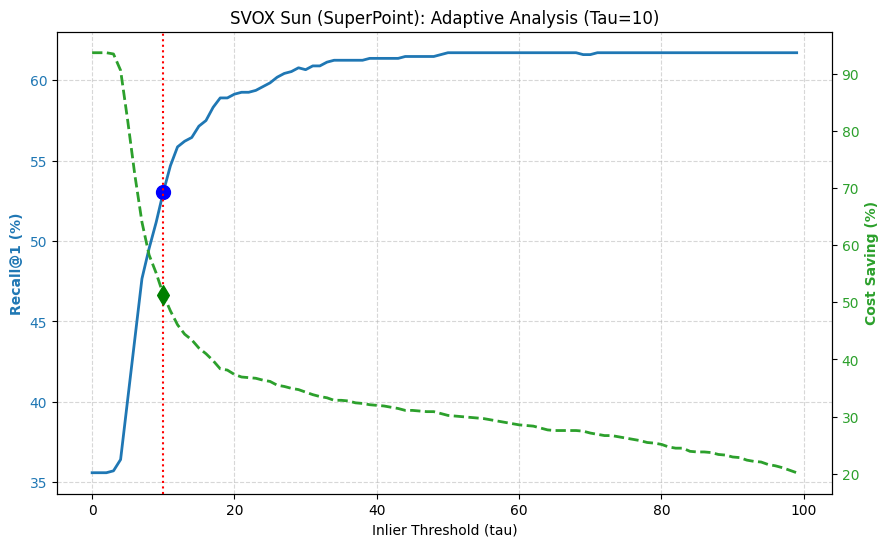


--- Caricamento SVOX Night Test (SuperPoint) ---


Parsing TXT: 100%|██████████| 823/823 [00:00<00:00, 12792.63it/s]

📄 CSV: superpoint-lg_queries_night.csv



Loading Torch: 100%|██████████| 823/823 [12:43<00:00,  1.08it/s]



--- TRADE-OFF TABLE: SVOX Night (0-100) ---
Tau   | Recall     | Saving     | F2-Score   | Note
-----------------------------------------------------------------
0     | 8.63%    | 89.20%    | 0.1053     | 
5     | 13.85%    | 60.72%    | 0.1638     | 
9     | 21.75%    | 23.44%    | 0.2207     | ⭐ MAX F2 
10    | 22.72%    | 19.33%    | 0.2195     | ⬅️ CHOSEN 
15    | 24.42%    | 10.41%    | 0.1924     | 
20    | 24.79%    | 7.66%    | 0.1713     | 
25    | 25.15%    | 7.09%    | 0.1666     | 
30    | 25.27%    | 6.63%    | 0.1618     | 
35    | 25.27%    | 6.52%    | 0.1604     | 
40    | 25.27%    | 6.29%    | 0.1576     | 
45    | 25.27%    | 6.18%    | 0.1562     | 
50    | 25.27%    | 6.06%    | 0.1547     | 
55    | 25.39%    | 5.60%    | 0.1488     | 
60    | 25.39%    | 5.26%    | 0.1438     | 
65    | 25.39%    | 5.15%    | 0.1421     | 
70    | 25.39%    | 4.92%    | 0.1386     | 
75    | 25.39%    | 4.57%    | 0.1329     | 
80    | 25.39%    | 4.46%    | 0.1310     | 
85  

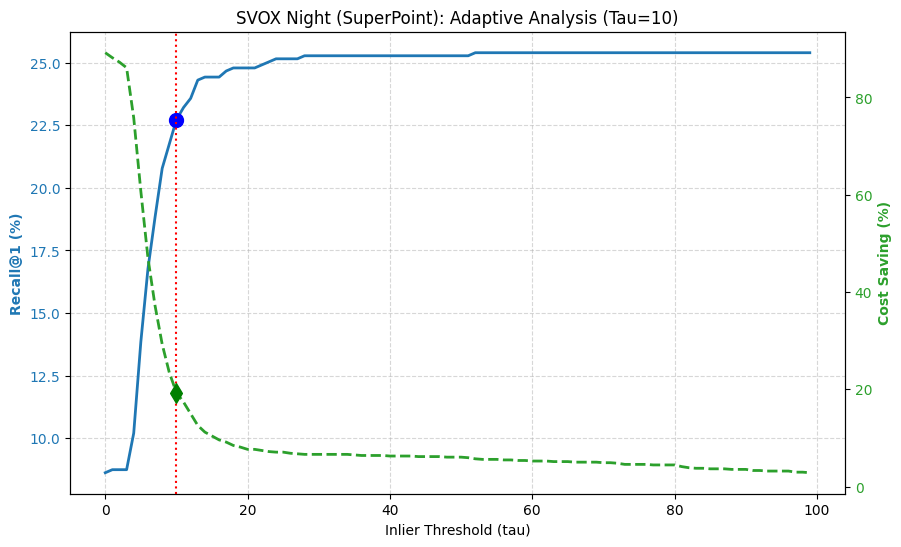



📊 FINAL COMPARISON (SuperPoint-LG)
Dataset         | Metric     | Baseline (Always)  | Adaptive (Tau=10)    | Delta
-----------------------------------------------------------------------------------------------
SVOX Sun        | Recall     | 61.71              % | 53.04                % | -8.67
                | Saving     | 0.00               % | 51.36                % | +51.36
-----------------------------------------------------------------------------------------------
SVOX Night      | Recall     | 25.39              % | 22.72                % | -2.67
                | Saving     | 0.00               % | 19.33                % | +19.33


In [35]:
import os
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURAZIONE PERCORSI (SVOX SUN & NIGHT - SUPERPOINT)
# ==============================================================================

# Percorsi base su Drive
BASE_SUN = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/test/svox_sun"
BASE_NIGHT = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/test/svox_night"

# Cartelle originali dei TXT su Drive
DRIVE_TXT_SUN = os.path.join(BASE_SUN, "preds_txt_generated")
DRIVE_TXT_NIGHT = os.path.join(BASE_NIGHT, "preds_txt_generated")

# Cartelle locali temporanee (per velocità)
LOCAL_TXT_SUN = "/content/temp_svox_sun_txt"
LOCAL_TXT_NIGHT = "/content/temp_svox_night_txt"

# Tau Scelto
CHOSEN_TAU = 10

# Parametri
TIME_GLOBAL = 0.20
TIME_RERANK = 3.20
FBETA = 2.0

# ==============================================================================
# 2. PREPARAZIONE DATI (COPIA LOCALE)
# ==============================================================================
def prepare_local_txt(drive_path, local_path):
    print(f"🚀 Copia TXT da {os.path.basename(drive_path)} a locale...")
    if os.path.exists(local_path):
        shutil.rmtree(local_path)
    if os.path.exists(drive_path):
        shutil.copytree(drive_path, local_path)
        print(f"✅ Copia completata in: {local_path}")
        return local_path
    else:
        print(f"⚠️ Attenzione: Cartella Drive non trovata: {drive_path}")
        return None

# ==============================================================================
# 3. FUNZIONI DI CARICAMENTO
# ==============================================================================

def norm_qid(x) -> str | None:
    try:
        return f"{int(float(x)):03d}"
    except Exception:
        return None

def parse_preds_txt(txt_path: str) -> dict | None:
    qid = norm_qid(Path(txt_path).stem)
    if qid is None: return None

    with open(txt_path, "r", encoding="utf-8") as f:
        lines = [ln.strip() for ln in f.readlines()]

    try:
        i_pred = next(i for i, x in enumerate(lines) if x.startswith("Predictions paths"))
        i_pos = next(i for i, x in enumerate(lines) if x.startswith("Positives paths"))
    except StopIteration:
        return None

    pred_lines = [ln for ln in lines[i_pred + 1 : i_pos] if ln and not ln.endswith(":")]
    pos_lines = [ln for ln in lines[i_pos + 1 :] if ln and not ln.endswith(":")]

    if not pred_lines: return None

    rank0 = pred_lines[0]
    positives = set(pos_lines)
    retrieval_is_correct = 1 if rank0 in positives else 0
    return {"query_id": qid, "retrieval_is_correct": retrieval_is_correct}

def find_csv(base_path):
    # Lista candidati per SuperPoint
    candidates = [
        "stats_preds_superpoint_lg.csv",
        "superpoint_lg_queries_sun.csv",
        "superpoint_lg_queries_night.csv",
        "superpoint_lg_test.csv",
        "superpoint-lg_test.csv",
        "stats_preds_superpoint.csv"
    ]

    search_dirs = [base_path, os.path.dirname(base_path)]
    if base_path.endswith("_test"):
        search_dirs.append(base_path.replace("_test", ""))

    for d in search_dirs:
        if not os.path.exists(d): continue
        for name in candidates:
            p = os.path.join(d, name)
            if os.path.exists(p): return p

        # Fallback wildcard
        generic = glob(os.path.join(d, "*superpoint*.csv"))
        if generic: return generic[0]

    return None

def load_dataset_rigorous(base_path, txt_folder, dataset_label):
    print(f"\n--- Caricamento {dataset_label} (SuperPoint) ---")

    if not txt_folder or not os.path.exists(txt_folder):
        print(f"❌ Errore: Cartella TXT non valida.")
        return pd.DataFrame()

    # 1. Parsing TXT
    txt_files = glob(os.path.join(txt_folder, "*.txt"))
    if not txt_files:
        print(f"❌ Errore: Nessun file .txt in {txt_folder}")
        return pd.DataFrame()

    rows = [parse_preds_txt(p) for p in tqdm(txt_files, desc="Parsing TXT")]
    rows = [r for r in rows if r is not None]
    df_ret = pd.DataFrame(rows)

    # 2. Carica CSV
    csv_file = find_csv(base_path)
    if not csv_file:
        print(f"❌ Errore: Nessun CSV SuperPoint trovato per {dataset_label}")
        return pd.DataFrame()

    print(f"📄 CSV: {os.path.basename(csv_file)}")
    df_csv = pd.read_csv(csv_file)
    col_corr = 'is_correct' if 'is_correct' in df_csv.columns else 'final_is_correct'
    if col_corr not in df_csv.columns:
        print(f"⚠️ Colonna '{col_corr}' mancante nel CSV.")
        return pd.DataFrame()

    df_csv['query_id'] = df_csv['query_id'].apply(norm_qid)
    df_final = df_csv[['query_id', col_corr]].rename(columns={col_corr: 'final_is_correct'})

    # 3. Carica Torch (SuperPoint)
    # Cerchiamo la cartella specifica di SuperPoint
    torch_folder = os.path.join(base_path, "preds_superpoint-lg")

    # Fallback se non esiste
    if not os.path.exists(torch_folder):
        torch_folder = os.path.join(base_path, "preds_superpoint_lg") # con underscore

    if not os.path.exists(torch_folder):
        print(f"❌ Errore: Cartella Torch non trovata ({torch_folder})")
        return pd.DataFrame()

    common_qids = set(df_ret['query_id']) & set(df_final['query_id'])

    rows_torch = []
    for qid in tqdm(common_qids, desc="Loading Torch"):
        candidates = [
            os.path.join(torch_folder, f"{qid}.torch"),
            os.path.join(torch_folder, f"{int(qid)}.torch"),
            os.path.join(torch_folder, f"{int(qid):05d}.torch")
        ]
        for p in candidates:
            if os.path.exists(p):
                try:
                    data = torch.load(p, weights_only=False)
                    if data and 'num_inliers' in data[0]:
                        rows_torch.append({
                            "query_id": qid,
                            "inliers_rank0": int(data[0]['num_inliers'])
                        })
                        break
                except: pass

    df_inl = pd.DataFrame(rows_torch)
    if df_inl.empty:
        print("❌ Warning: Nessun inlier caricato.")
        return pd.DataFrame()

    df = df_ret.merge(df_final, on='query_id').merge(df_inl, on='query_id')
    return df

# ==============================================================================
# 4. ANALISI E REPORT
# ==============================================================================

def fbeta_score(recall, saving, beta=2.0):
    r = recall / 100.0
    s = saving / 100.0
    if (beta**2 * s + r) == 0: return 0
    return (1 + beta**2) * (r * s) / (beta**2 * s + r)

def analyze_and_report(df, dataset_name, chosen_tau):
    max_inl = df['inliers_rank0'].max()
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings, f2_scores = [], [], []
    total = len(df)
    full_time = total * (TIME_GLOBAL + TIME_RERANK)

    for t in thresholds:
        is_easy = df['inliers_rank0'] > t
        hits = np.where(is_easy, df['retrieval_is_correct'], df['final_is_correct']).sum()
        rec = (hits / total) * 100

        n_easy = is_easy.sum()
        n_hard = total - n_easy
        curr_time = (n_easy * TIME_GLOBAL) + (n_hard * (TIME_GLOBAL + TIME_RERANK))
        sav = (1 - (curr_time / full_time)) * 100

        recalls.append(rec)
        savings.append(sav)
        f2_scores.append(fbeta_score(rec, sav, beta=FBETA))

    # --- TABELLA ---
    print(f"\n--- TRADE-OFF TABLE: {dataset_name} (0-100) ---")
    print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F2-Score':<10} | {'Note'}")
    print("-" * 65)

    best_idx_auto = np.argmax(f2_scores)
    best_tau_auto = thresholds[best_idx_auto]

    indices = sorted(list(set(range(0, 101, 5)) | {chosen_tau, best_tau_auto}))

    for t_val in indices:
        if t_val < len(thresholds):
            idx = np.where(thresholds == t_val)[0][0]
            note = ""
            if t_val == chosen_tau: note += "⬅️ CHOSEN "
            if t_val == best_tau_auto: note += "⭐ MAX F2 "
            print(f"{t_val:<5} | {recalls[idx]:.2f}%    | {savings[idx]:.2f}%    | {f2_scores[idx]:.4f}     | {note}")
    print("-" * 65)

    # --- PLOT ---
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Inlier Threshold (tau)')
    ax1.set_ylabel('Recall@1 (%)', color='tab:blue', fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.5)

    limit_plot = min(100, len(thresholds))
    ax1.plot(thresholds[:limit_plot], recalls[:limit_plot], color='tab:blue', linewidth=2, label='Recall@1')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Cost Saving (%)', color='tab:green', fontweight='bold')
    ax2.plot(thresholds[:limit_plot], savings[:limit_plot], color='tab:green', linestyle='--', linewidth=2, label='Cost Saving')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    idx_chosen = min(chosen_tau, len(thresholds)-1)
    ax1.scatter(chosen_tau, recalls[idx_chosen], color='blue', s=100, zorder=5)
    ax2.scatter(chosen_tau, savings[idx_chosen], color='green', s=100, marker='d', zorder=5)

    plt.axvline(x=chosen_tau, color='red', linestyle=':', label=f'Tau={chosen_tau}')
    plt.title(f'{dataset_name} (SuperPoint): Adaptive Analysis (Tau={chosen_tau})')
    plt.show()

    idx_chosen = min(chosen_tau, len(recalls)-1)
    return df['final_is_correct'].mean() * 100, 0.0, recalls[idx_chosen], savings[idx_chosen]

# ==============================================================================
# 5. MAIN
# ==============================================================================
if __name__ == "__main__":

    # 1. Copia i file TXT in locale (VELOCIZZA PARSING)
    txt_sun_local = prepare_local_txt(DRIVE_TXT_SUN, LOCAL_TXT_SUN)
    txt_night_local = prepare_local_txt(DRIVE_TXT_NIGHT, LOCAL_TXT_NIGHT)

    # 2. Analisi SVOX Sun
    df_sun = load_dataset_rigorous(BASE_SUN, txt_sun_local, "SVOX Sun Test")
    r_base_sun, s_base_sun, r_ad_sun, s_ad_sun = 0,0,0,0
    if not df_sun.empty:
        r_base_sun, s_base_sun, r_ad_sun, s_ad_sun = analyze_and_report(df_sun, "SVOX Sun", CHOSEN_TAU)

    # 3. Analisi SVOX Night
    df_night = load_dataset_rigorous(BASE_NIGHT, txt_night_local, "SVOX Night Test")
    r_base_night, s_base_night, r_ad_night, s_ad_night = 0,0,0,0
    if not df_night.empty:
        r_base_night, s_base_night, r_ad_night, s_ad_night = analyze_and_report(df_night, "SVOX Night", CHOSEN_TAU)

    # 4. Tabella Finale
    print("\n\n📊 FINAL COMPARISON (SuperPoint-LG)")
    print("=" * 95)
    print(f"{'Dataset':<15} | {'Metric':<10} | {'Baseline (Always)':<18} | {'Adaptive (Tau=' + str(CHOSEN_TAU) + ')':<20} | {'Delta'}")
    print("-" * 95)

    print(f"{'SVOX Sun':<15} | {'Recall':<10} | {r_base_sun:<18.2f} % | {r_ad_sun:<20.2f} % | {r_ad_sun-r_base_sun:+.2f}")
    print(f"{'':<15} | {'Saving':<10} | {s_base_sun:<18.2f} % | {s_ad_sun:<20.2f} % | {s_ad_sun-s_base_sun:+.2f}")
    print("-" * 95)

    print(f"{'SVOX Night':<15} | {'Recall':<10} | {r_base_night:<18.2f} % | {r_ad_night:<20.2f} % | {r_ad_night-r_base_night:+.2f}")
    print(f"{'':<15} | {'Saving':<10} | {s_base_night:<18.2f} % | {s_ad_night:<20.2f} % | {s_ad_night-s_base_night:+.2f}")
    print("=" * 95)

### Test sf_xs
Obiettivo: Valutare le prestazioni di SuperPoint + LightGlue sul dataset di test di San Francisco, utilizzando la soglia $\tau = 10$.

Aspettative: Confermare se il comportamento osservato in validazione (Recall leggermente superiore a LoFTR e Risparmio simile) si mantiene anche sul test set finale.

🚀 Copia TXT da Drive a locale (velocizza parsing)...
✅ Copia completata in: /content/temp_sfxs_test_txt

--- Caricamento SF-XS Test (SuperPoint) ---


Parsing TXT: 100%|██████████| 1000/1000 [00:00<00:00, 14058.81it/s]

📄 CSV: superpoint-lg_test.csv



Loading Torch: 100%|██████████| 1000/1000 [16:44<00:00,  1.00s/it]



--- TRADE-OFF TABLE: SF-XS Test (0-100) ---
Tau   | Recall     | Saving     | F2-Score   | Note
-----------------------------------------------------------------
0     | 27.80%    | 92.80%    | 0.3233     | 
5     | 34.50%    | 75.48%    | 0.3870     | 
10    | 47.20%    | 41.41%    | 0.4592     | ⬅️ CHOSEN 
11    | 48.70%    | 38.31%    | 0.4619     | ⭐ MAX F2 
15    | 51.70%    | 31.06%    | 0.4563     | 
20    | 52.60%    | 27.48%    | 0.4447     | 
25    | 52.90%    | 25.69%    | 0.4366     | 
30    | 53.00%    | 24.47%    | 0.4298     | 
35    | 53.10%    | 23.53%    | 0.4243     | 
40    | 53.30%    | 22.12%    | 0.4158     | 
45    | 53.40%    | 21.18%    | 0.4094     | 
50    | 53.50%    | 20.33%    | 0.4034     | 
55    | 53.50%    | 19.48%    | 0.3965     | 
60    | 53.50%    | 19.20%    | 0.3942     | 
65    | 53.30%    | 18.07%    | 0.3835     | 
70    | 53.40%    | 17.32%    | 0.3769     | 
75    | 53.40%    | 16.56%    | 0.3696     | 
80    | 53.40%    | 15.25%    | 0.35

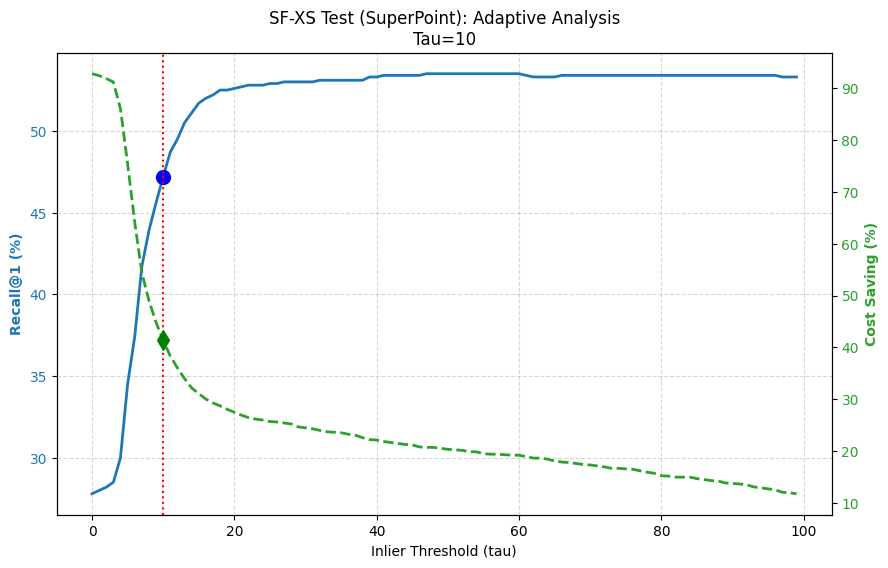



📊 FINAL COMPARISON (SuperPoint-LG)
Dataset         | Metric     | Baseline (Always)  | Adaptive (Tau=10)    | Delta
-----------------------------------------------------------------------------------------------
SF-XS Test      | Recall     | 53.20              % | 47.20                % | -6.00
                | Saving     | 0.00               % | 41.41                % | +41.41


In [36]:
import os
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURAZIONE PERCORSI (SF-XS TEST - SUPERPOINT)
# ==============================================================================

# Percorso base su Drive
BASE_PATH = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_sf_xs/test"

# Cartella originale dei TXT su Drive
DRIVE_TXT_FOLDER = os.path.join(BASE_PATH, "preds_txt_generated")

# Cartella locale temporanea (velocizza di 100x il caricamento)
LOCAL_TXT_FOLDER = "/content/temp_sfxs_test_txt"

# Tau Scelto
CHOSEN_TAU = 10

# Parametri
TIME_GLOBAL = 0.20
TIME_RERANK = 3.20
FBETA = 2.0

# ==============================================================================
# 2. PREPARAZIONE DATI (COPIA LOCALE)
# ==============================================================================
def prepare_local_txt(drive_path, local_path):
    print(f"🚀 Copia TXT da Drive a locale (velocizza parsing)...")
    if os.path.exists(local_path):
        shutil.rmtree(local_path)

    if os.path.exists(drive_path):
        shutil.copytree(drive_path, local_path)
        print(f"✅ Copia completata in: {local_path}")
        return local_path
    else:
        print(f"⚠️ Attenzione: Cartella Drive non trovata: {drive_path}")
        return None

# ==============================================================================
# 3. FUNZIONI DI CARICAMENTO
# ==============================================================================

def norm_qid(x) -> str | None:
    try:
        return f"{int(float(x)):03d}"
    except Exception:
        return None

def parse_preds_txt(txt_path: str) -> dict | None:
    qid = norm_qid(Path(txt_path).stem)
    if qid is None: return None

    with open(txt_path, "r", encoding="utf-8") as f:
        lines = [ln.strip() for ln in f.readlines()]

    try:
        i_pred = next(i for i, x in enumerate(lines) if x.startswith("Predictions paths"))
        i_pos = next(i for i, x in enumerate(lines) if x.startswith("Positives paths"))
    except StopIteration:
        return None

    pred_lines = [ln for ln in lines[i_pred + 1 : i_pos] if ln and not ln.endswith(":")]
    pos_lines = [ln for ln in lines[i_pos + 1 :] if ln and not ln.endswith(":")]

    if not pred_lines: return None

    rank0 = pred_lines[0]
    positives = set(pos_lines)
    retrieval_is_correct = 1 if rank0 in positives else 0
    return {"query_id": qid, "retrieval_is_correct": retrieval_is_correct}

def find_csv(base_path):
    # Lista candidati per SuperPoint
    candidates = [
        "stats_preds_superpoint_lg.csv",
        "superpoint_lg_test.csv",
        "superpoint-lg_test.csv",
        "superpoint_lg_sf_xs_test.csv",
        "superpoint-lg_stats_final.csv"
    ]

    search_dirs = [base_path, os.path.dirname(base_path)]

    for d in search_dirs:
        if not os.path.exists(d): continue
        for name in candidates:
            p = os.path.join(d, name)
            if os.path.exists(p): return p

        # Fallback wildcard
        generic = glob(os.path.join(d, "*superpoint*.csv"))
        if generic: return generic[0]

    return None

def load_dataset_rigorous(base_path, txt_folder, dataset_label):
    print(f"\n--- Caricamento {dataset_label} (SuperPoint) ---")

    if not txt_folder or not os.path.exists(txt_folder):
        print(f"❌ Errore: Cartella TXT locale non valida.")
        return pd.DataFrame()

    # 1. Parsing TXT
    txt_files = glob(os.path.join(txt_folder, "*.txt"))
    if not txt_files:
        print(f"❌ Errore: Nessun file .txt in {txt_folder}")
        return pd.DataFrame()

    rows = [parse_preds_txt(p) for p in tqdm(txt_files, desc="Parsing TXT")]
    rows = [r for r in rows if r is not None]
    df_ret = pd.DataFrame(rows)

    # 2. Carica CSV
    csv_file = find_csv(base_path)
    if not csv_file:
        print(f"❌ Errore: Nessun CSV SuperPoint trovato per {dataset_label}")
        return pd.DataFrame()

    print(f"📄 CSV: {os.path.basename(csv_file)}")
    df_csv = pd.read_csv(csv_file)
    col_corr = 'is_correct' if 'is_correct' in df_csv.columns else 'final_is_correct'
    if col_corr not in df_csv.columns:
        print(f"⚠️ Colonna '{col_corr}' mancante nel CSV.")
        return pd.DataFrame()

    df_csv['query_id'] = df_csv['query_id'].apply(norm_qid)
    df_final = df_csv[['query_id', col_corr]].rename(columns={col_corr: 'final_is_correct'})

    # 3. Carica Torch (SuperPoint)
    torch_folder = os.path.join(base_path, "preds_superpoint-lg")

    if not os.path.exists(torch_folder):
        torch_folder = os.path.join(base_path, "preds_superpoint_lg") # fallback underscore

    if not os.path.exists(torch_folder):
        print(f"❌ Errore: Cartella Torch non trovata ({torch_folder})")
        return pd.DataFrame()

    common_qids = set(df_ret['query_id']) & set(df_final['query_id'])

    rows_torch = []
    for qid in tqdm(common_qids, desc="Loading Torch"):
        candidates = [
            os.path.join(torch_folder, f"{qid}.torch"),
            os.path.join(torch_folder, f"{int(qid)}.torch"),
            os.path.join(torch_folder, f"{int(qid):05d}.torch")
        ]
        for p in candidates:
            if os.path.exists(p):
                try:
                    data = torch.load(p, weights_only=False)
                    if data and 'num_inliers' in data[0]:
                        rows_torch.append({
                            "query_id": qid,
                            "inliers_rank0": int(data[0]['num_inliers'])
                        })
                        break
                except: pass

    df_inl = pd.DataFrame(rows_torch)
    if df_inl.empty:
        print("❌ Warning: Nessun inlier caricato.")
        return pd.DataFrame()

    df = df_ret.merge(df_final, on='query_id').merge(df_inl, on='query_id')
    return df

# ==============================================================================
# 4. ANALISI E REPORT
# ==============================================================================

def fbeta_score(recall, saving, beta=2.0):
    r = recall / 100.0
    s = saving / 100.0
    if (beta**2 * s + r) == 0: return 0
    return (1 + beta**2) * (r * s) / (beta**2 * s + r)

def analyze_and_report(df, dataset_name, chosen_tau):
    max_inl = df['inliers_rank0'].max()
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings, f2_scores = [], [], []
    total = len(df)
    full_time = total * (TIME_GLOBAL + TIME_RERANK)

    for t in thresholds:
        is_easy = df['inliers_rank0'] > t
        hits = np.where(is_easy, df['retrieval_is_correct'], df['final_is_correct']).sum()
        rec = (hits / total) * 100

        n_easy = is_easy.sum()
        n_hard = total - n_easy
        curr_time = (n_easy * TIME_GLOBAL) + (n_hard * (TIME_GLOBAL + TIME_RERANK))
        sav = (1 - (curr_time / full_time)) * 100

        recalls.append(rec)
        savings.append(sav)
        f2_scores.append(fbeta_score(rec, sav, beta=FBETA))

    # --- TABELLA ---
    print(f"\n--- TRADE-OFF TABLE: {dataset_name} (0-100) ---")
    print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F2-Score':<10} | {'Note'}")
    print("-" * 65)

    best_idx_auto = np.argmax(f2_scores)
    best_tau_auto = thresholds[best_idx_auto]

    indices = sorted(list(set(range(0, 101, 5)) | {chosen_tau, best_tau_auto}))

    for t_val in indices:
        if t_val < len(thresholds):
            idx = np.where(thresholds == t_val)[0][0]
            note = ""
            if t_val == chosen_tau: note += "⬅️ CHOSEN "
            if t_val == best_tau_auto: note += "⭐ MAX F2 "
            print(f"{t_val:<5} | {recalls[idx]:.2f}%    | {savings[idx]:.2f}%    | {f2_scores[idx]:.4f}     | {note}")
    print("-" * 65)

    # --- PLOT ---
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Inlier Threshold (tau)')
    ax1.set_ylabel('Recall@1 (%)', color='tab:blue', fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.5)

    limit_plot = min(100, len(thresholds))
    ax1.plot(thresholds[:limit_plot], recalls[:limit_plot], color='tab:blue', linewidth=2, label='Recall@1')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Cost Saving (%)', color='tab:green', fontweight='bold')
    ax2.plot(thresholds[:limit_plot], savings[:limit_plot], color='tab:green', linestyle='--', linewidth=2, label='Cost Saving')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    idx_chosen = min(chosen_tau, len(thresholds)-1)
    ax1.scatter(chosen_tau, recalls[idx_chosen], color='blue', s=100, zorder=5)
    ax2.scatter(chosen_tau, savings[idx_chosen], color='green', s=100, marker='d', zorder=5)

    plt.axvline(x=chosen_tau, color='red', linestyle=':', label=f'Tau={chosen_tau}')
    plt.title(f'{dataset_name} (SuperPoint): Adaptive Analysis\nTau={chosen_tau}')
    plt.show()

    idx_chosen = min(chosen_tau, len(recalls)-1)
    return df['final_is_correct'].mean() * 100, 0.0, recalls[idx_chosen], savings[idx_chosen]

# ==============================================================================
# 5. MAIN
# ==============================================================================
if __name__ == "__main__":

    # 1. Copia i file TXT in locale (VELOCIZZA)
    txt_local = prepare_local_txt(DRIVE_TXT_FOLDER, LOCAL_TXT_FOLDER)

    # 2. Analisi SF-XS Test
    df_test = load_dataset_rigorous(BASE_PATH, txt_local, "SF-XS Test")

    r_base, s_base, r_ad, s_ad = 0,0,0,0

    if not df_test.empty:
        r_base, s_base, r_ad, s_ad = analyze_and_report(df_test, "SF-XS Test", CHOSEN_TAU)

        # 3. Tabella Finale
        print("\n\n📊 FINAL COMPARISON (SuperPoint-LG)")
        print("=" * 95)
        print(f"{'Dataset':<15} | {'Metric':<10} | {'Baseline (Always)':<18} | {'Adaptive (Tau=' + str(CHOSEN_TAU) + ')':<20} | {'Delta'}")
        print("-" * 95)
        print(f"{'SF-XS Test':<15} | {'Recall':<10} | {r_base:<18.2f} % | {r_ad:<20.2f} % | {r_ad-r_base:+.2f}")
        print(f"{'':<15} | {'Saving':<10} | {s_base:<18.2f} % | {s_ad:<20.2f} % | {s_ad-s_base:+.2f}")
        print("=" * 95)

### Test tokyo_xs
Obiettivo:
Concludiamo la sperimentazione applicando SuperPoint + LightGlue con soglia $\tau=12$ al dataset Tokyo-XS.
Questo test finale ci permetterà di confrontare la generalizzazione di SP+LG rispetto a LoFTR in un ambiente urbano complesso e diverso da quelli di training.

🚀 Copia TXT da Drive a locale (velocizza parsing)...
✅ Copia completata in: /content/temp_tokyo_txt

--- Caricamento Tokyo XS Test (SuperPoint) ---


Parsing TXT: 100%|██████████| 315/315 [00:00<00:00, 6233.28it/s]

📄 CSV: superpoint-lg_stats_final.csv



Loading Torch: 100%|██████████| 315/315 [05:01<00:00,  1.04it/s]



--- TRADE-OFF TABLE: Tokyo XS (0-100) ---
Tau   | Recall     | Saving     | F2-Score   | Note
-----------------------------------------------------------------
0     | 50.48%    | 92.03%    | 0.5549     | 
5     | 57.14%    | 73.20%    | 0.5977     | 
7     | 62.86%    | 57.07%    | 0.6161     | ⭐ MAX F2 
10    | 64.44%    | 50.49%    | 0.6107     | ⬅️ CHOSEN 
15    | 66.98%    | 44.52%    | 0.6084     | 
20    | 67.62%    | 43.32%    | 0.6080     | 
25    | 67.94%    | 41.83%    | 0.6040     | 
30    | 68.25%    | 40.34%    | 0.5995     | 
35    | 68.25%    | 38.54%    | 0.5914     | 
40    | 68.25%    | 37.65%    | 0.5871     | 
45    | 68.25%    | 35.56%    | 0.5765     | 
50    | 68.25%    | 32.87%    | 0.5616     | 
55    | 68.25%    | 31.37%    | 0.5526     | 
60    | 68.25%    | 29.58%    | 0.5411     | 
65    | 68.25%    | 27.79%    | 0.5286     | 
70    | 68.25%    | 25.40%    | 0.5103     | 
75    | 68.25%    | 23.01%    | 0.4899     | 
80    | 68.25%    | 21.51%    | 0.4758

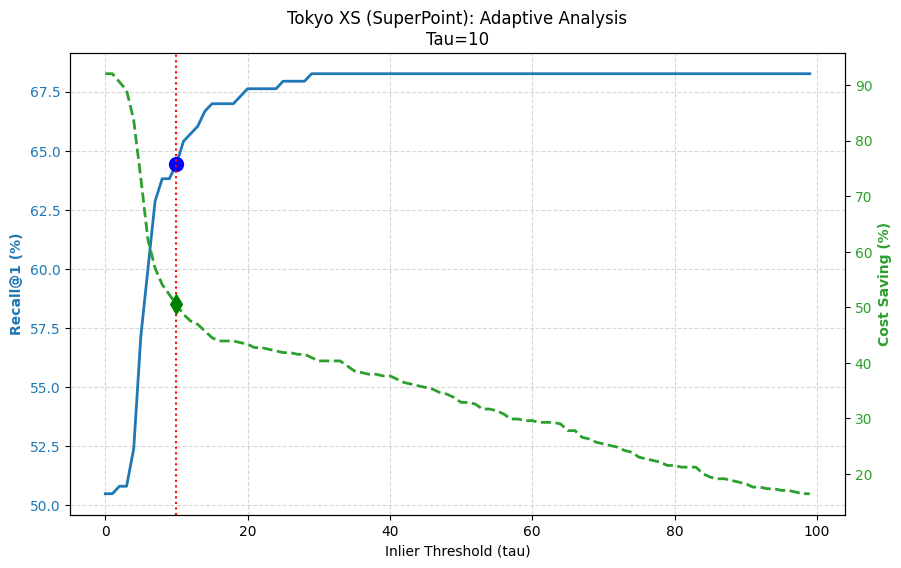



📊 FINAL COMPARISON (SuperPoint-LG)
Dataset         | Metric     | Baseline (Always)  | Adaptive (Tau=10)    | Delta
-----------------------------------------------------------------------------------------------
Tokyo XS        | Recall     | 68.25              % | 64.44                % | -3.81
                | Saving     | 0.00               % | 50.49                % | +50.49


In [38]:
import os
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURAZIONE PERCORSI (TOKYO XS - SUPERPOINT)
# ==============================================================================

# Percorso base su Drive (Tokyo XS Test)
BASE_TOKYO = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_tokyo"

# Cartella originale dei TXT su Drive
DRIVE_TXT_TOKYO = os.path.join(BASE_TOKYO, "preds_txt_generated")

# Cartella locale temporanea (per velocità)
LOCAL_TXT_TOKYO = "/content/temp_tokyo_txt"

# Tau Scelto
CHOSEN_TAU = 10

# Parametri
TIME_GLOBAL = 0.20
TIME_RERANK = 3.20
FBETA = 2.0

# ==============================================================================
# 2. PREPARAZIONE DATI (COPIA LOCALE)
# ==============================================================================
def prepare_local_txt(drive_path, local_path):
    print(f"🚀 Copia TXT da Drive a locale (velocizza parsing)...")
    if os.path.exists(local_path):
        shutil.rmtree(local_path)

    if os.path.exists(drive_path):
        shutil.copytree(drive_path, local_path)
        print(f"✅ Copia completata in: {local_path}")
        return local_path
    else:
        print(f"⚠️ Attenzione: Cartella Drive non trovata: {drive_path}")
        # Prova a cercare nella cartella padre se il path è leggermente diverso
        parent = os.path.dirname(drive_path)
        alt_path = os.path.join(parent, "netvlad_tokyo", "test", "preds_txt_generated")
        if os.path.exists(alt_path):
             print(f"🔄 Trovata in percorso alternativo: {alt_path}")
             shutil.copytree(alt_path, local_path)
             return local_path
        return None

# ==============================================================================
# 3. FUNZIONI DI CARICAMENTO
# ==============================================================================

def norm_qid(x) -> str | None:
    try:
        return f"{int(float(x)):03d}"
    except Exception:
        return None

def parse_preds_txt(txt_path: str) -> dict | None:
    qid = norm_qid(Path(txt_path).stem)
    if qid is None: return None

    with open(txt_path, "r", encoding="utf-8") as f:
        lines = [ln.strip() for ln in f.readlines()]

    try:
        i_pred = next(i for i, x in enumerate(lines) if x.startswith("Predictions paths"))
        i_pos = next(i for i, x in enumerate(lines) if x.startswith("Positives paths"))
    except StopIteration:
        return None

    pred_lines = [ln for ln in lines[i_pred + 1 : i_pos] if ln and not ln.endswith(":")]
    pos_lines = [ln for ln in lines[i_pos + 1 :] if ln and not ln.endswith(":")]

    if not pred_lines: return None

    rank0 = pred_lines[0]
    positives = set(pos_lines)
    retrieval_is_correct = 1 if rank0 in positives else 0
    return {"query_id": qid, "retrieval_is_correct": retrieval_is_correct}

def find_csv(base_path):
    # Lista candidati per SuperPoint su Tokyo
    candidates = [
        "stats_preds_superpoint_lg.csv",
        "superpoint_lg_test.csv",
        "superpoint-lg_test.csv",
        "superpoint_lg_tokyo_xs_test.csv",
        "superpoint-lg_stats_final.csv"
    ]

    search_dirs = [base_path, os.path.dirname(base_path)]
    # Aggiungi cartella padre se base finisce con test
    if base_path.endswith("test"):
        search_dirs.append(os.path.dirname(base_path))

    for d in search_dirs:
        if not os.path.exists(d): continue
        for name in candidates:
            p = os.path.join(d, name)
            if os.path.exists(p): return p

        # Fallback wildcard
        generic = glob(os.path.join(d, "*superpoint*.csv"))
        if generic: return generic[0]

    return None

def load_dataset_rigorous(base_path, txt_folder, dataset_label):
    print(f"\n--- Caricamento {dataset_label} (SuperPoint) ---")

    if not txt_folder or not os.path.exists(txt_folder):
        print(f"❌ Errore: Cartella TXT locale non valida.")
        return pd.DataFrame()

    # 1. Parsing TXT
    txt_files = glob(os.path.join(txt_folder, "*.txt"))
    if not txt_files:
        print(f"❌ Errore: Nessun file .txt in {txt_folder}")
        return pd.DataFrame()

    rows = [parse_preds_txt(p) for p in tqdm(txt_files, desc="Parsing TXT")]
    rows = [r for r in rows if r is not None]
    df_ret = pd.DataFrame(rows)

    # 2. Carica CSV
    csv_file = find_csv(base_path)
    if not csv_file:
        print(f"❌ Errore: Nessun CSV SuperPoint trovato per {dataset_label}")
        return pd.DataFrame()

    print(f"📄 CSV: {os.path.basename(csv_file)}")
    df_csv = pd.read_csv(csv_file)
    col_corr = 'is_correct' if 'is_correct' in df_csv.columns else 'final_is_correct'
    if col_corr not in df_csv.columns:
        print(f"⚠️ Colonna '{col_corr}' mancante nel CSV.")
        return pd.DataFrame()

    df_csv['query_id'] = df_csv['query_id'].apply(norm_qid)
    df_final = df_csv[['query_id', col_corr]].rename(columns={col_corr: 'final_is_correct'})

    # 3. Carica Torch (SuperPoint)
    # Cerchiamo la cartella specifica di SuperPoint
    torch_folder = os.path.join(base_path, "preds_superpoint-lg")

    # Fallback se non esiste (underscore invece di trattino)
    if not os.path.exists(torch_folder):
        torch_folder = os.path.join(base_path, "preds_superpoint_lg")

    # Fallback livello superiore
    if not os.path.exists(torch_folder):
        torch_folder = os.path.join(os.path.dirname(base_path), "preds_superpoint-lg")

    if not os.path.exists(torch_folder):
        print(f"❌ Errore: Cartella Torch non trovata ({torch_folder})")
        return pd.DataFrame()

    common_qids = set(df_ret['query_id']) & set(df_final['query_id'])

    rows_torch = []
    for qid in tqdm(common_qids, desc="Loading Torch"):
        candidates = [
            os.path.join(torch_folder, f"{qid}.torch"),
            os.path.join(torch_folder, f"{int(qid)}.torch"),
            os.path.join(torch_folder, f"{int(qid):05d}.torch")
        ]
        for p in candidates:
            if os.path.exists(p):
                try:
                    data = torch.load(p, weights_only=False)
                    if data and 'num_inliers' in data[0]:
                        rows_torch.append({
                            "query_id": qid,
                            "inliers_rank0": int(data[0]['num_inliers'])
                        })
                        break
                except: pass

    df_inl = pd.DataFrame(rows_torch)
    if df_inl.empty:
        print("❌ Warning: Nessun inlier caricato.")
        return pd.DataFrame()

    df = df_ret.merge(df_final, on='query_id').merge(df_inl, on='query_id')
    return df

# ==============================================================================
# 4. ANALISI E REPORT
# ==============================================================================

def fbeta_score(recall, saving, beta=2.0):
    r = recall / 100.0
    s = saving / 100.0
    if (beta**2 * s + r) == 0: return 0
    return (1 + beta**2) * (r * s) / (beta**2 * s + r)

def analyze_and_report(df, dataset_name, chosen_tau):
    max_inl = df['inliers_rank0'].max()
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings, f2_scores = [], [], []
    total = len(df)
    full_time = total * (TIME_GLOBAL + TIME_RERANK)

    for t in thresholds:
        is_easy = df['inliers_rank0'] > t
        hits = np.where(is_easy, df['retrieval_is_correct'], df['final_is_correct']).sum()
        rec = (hits / total) * 100

        n_easy = is_easy.sum()
        n_hard = total - n_easy
        curr_time = (n_easy * TIME_GLOBAL) + (n_hard * (TIME_GLOBAL + TIME_RERANK))
        sav = (1 - (curr_time / full_time)) * 100

        recalls.append(rec)
        savings.append(sav)
        f2_scores.append(fbeta_score(rec, sav, beta=FBETA))

    # --- TABELLA ---
    print(f"\n--- TRADE-OFF TABLE: {dataset_name} (0-100) ---")
    print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F2-Score':<10} | {'Note'}")
    print("-" * 65)

    best_idx_auto = np.argmax(f2_scores)
    best_tau_auto = thresholds[best_idx_auto]

    indices = sorted(list(set(range(0, 101, 5)) | {chosen_tau, best_tau_auto}))

    for t_val in indices:
        if t_val < len(thresholds):
            idx = np.where(thresholds == t_val)[0][0]
            note = ""
            if t_val == chosen_tau: note += "⬅️ CHOSEN "
            if t_val == best_tau_auto: note += "⭐ MAX F2 "
            print(f"{t_val:<5} | {recalls[idx]:.2f}%    | {savings[idx]:.2f}%    | {f2_scores[idx]:.4f}     | {note}")
    print("-" * 65)

    # --- PLOT ---
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Inlier Threshold (tau)')
    ax1.set_ylabel('Recall@1 (%)', color='tab:blue', fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.5)

    limit_plot = min(100, len(thresholds))
    ax1.plot(thresholds[:limit_plot], recalls[:limit_plot], color='tab:blue', linewidth=2, label='Recall@1')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Cost Saving (%)', color='tab:green', fontweight='bold')
    ax2.plot(thresholds[:limit_plot], savings[:limit_plot], color='tab:green', linestyle='--', linewidth=2, label='Cost Saving')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    idx_chosen = min(chosen_tau, len(thresholds)-1)
    ax1.scatter(chosen_tau, recalls[idx_chosen], color='blue', s=100, zorder=5)
    ax2.scatter(chosen_tau, savings[idx_chosen], color='green', s=100, marker='d', zorder=5)

    plt.axvline(x=chosen_tau, color='red', linestyle=':', label=f'Tau={chosen_tau}')
    plt.title(f'{dataset_name} (SuperPoint): Adaptive Analysis\nTau={chosen_tau}')
    plt.show()

    idx_chosen = min(chosen_tau, len(recalls)-1)
    return df['final_is_correct'].mean() * 100, 0.0, recalls[idx_chosen], savings[idx_chosen]

# ==============================================================================
# 5. MAIN
# ==============================================================================
if __name__ == "__main__":

    # 1. Copia i file TXT in locale (VELOCIZZA)
    txt_tokyo_local = prepare_local_txt(DRIVE_TXT_TOKYO, LOCAL_TXT_TOKYO)

    # 2. Analisi Tokyo XS
    df_tokyo = load_dataset_rigorous(BASE_TOKYO, txt_tokyo_local, "Tokyo XS Test")

    r_base, s_base, r_ad, s_ad = 0,0,0,0

    if not df_tokyo.empty:
        r_base, s_base, r_ad, s_ad = analyze_and_report(df_tokyo, "Tokyo XS", CHOSEN_TAU)

        # 3. Tabella Finale
        print("\n\n📊 FINAL COMPARISON (SuperPoint-LG)")
        print("=" * 95)
        print(f"{'Dataset':<15} | {'Metric':<10} | {'Baseline (Always)':<18} | {'Adaptive (Tau=' + str(CHOSEN_TAU) + ')':<20} | {'Delta'}")
        print("-" * 95)
        print(f"{'Tokyo XS':<15} | {'Recall':<10} | {r_base:<18.2f} % | {r_ad:<20.2f} % | {r_ad-r_base:+.2f}")
        print(f"{'':<15} | {'Saving':<10} | {s_base:<18.2f} % | {s_ad:<20.2f} % | {s_ad-s_base:+.2f}")
        print("=" * 95)